This project works on the music instrument sound to classify them

The dataset is taken from: https://www.kaggle.com/datasets/abdulvahap/music-instrunment-sounds-for-classification

<H3>Before start, some set up should be done to make the training smoother</H3>

In this project, VS Code with Jupyter Notebook is used in a virtual environment of WSL: Ubuntu, so that the latest version of Tensorflow can be run using GPU (OS is Windows 11)

**Check GPU Availability** to shorten model training time

In [63]:
import tensorflow as tf

# Show TensorFlow version and list available GPUs
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.20.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Enable GPU Memory Growth** to prevent it takes all memory at once and avoid out-of-memory error

In [2]:
# setting memory growth for GPUs
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    print('GPU setup successful!')

GPU setup successful!


---

List classes and count audio files

In [3]:
from pathlib import Path
import pandas as pd

# Dataset root folder, each subfolder is presenting one class
DATA_DIR = Path("../music_dataset/").resolve()

# Collect subfolders
class_dirs = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])

# Build a dataframe table, class name and count
df_counts = pd.DataFrame(
    [(d.name, sum(1 for _ in d.glob("*.wav"))) for d in class_dirs],
    columns=["class", "count"]
).sort_values("count", ascending=False).reset_index(drop=True)

print(f"Total classes: {len(df_counts)}")
print(f"Total wavs: {int(df_counts['count'].sum())}")

Total classes: 28
Total wavs: 42311


In [4]:
display(df_counts)

class  count
0             flute   3719
1   Acoustic_Guitar   3654
2          Drum_set   3648
3       Bass_Guitar   3613
4         Accordion   3581
5             Banjo   2998
6          Trombone   2965
7          Mandolin   2458
8          Keyboard   2041
9             Organ   1442
10          Shakers   1357
11   Electro_Guitar   1316
12        Harmonium   1314
13             Horn   1258
14          Ukulele    790
15         Clarinet    634
16           Violin    630
17          cowbell    621
18            Piano    575
19       Tambourine    558
20       vibraphone    506
21          Trumpet    503
22            Dobro    487
23        Saxophone    454
24          Hi_Hats    444
25        Floor_Tom    406
26          Cymbals    208
27        Harmonica    131

Get only classes with more than **1000 audio files** to reduce number of classes and total time

In [5]:
THRESHOLD = 1000 # minimum clips per class to keep

# Keep only classes with more than 1000 data
df_counts = (
    df_counts[df_counts["count"] > THRESHOLD]
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print(f"Classes with > {THRESHOLD} files: {len(df_counts)}")

Classes with > 1000 files: 14


In [6]:
display(df_counts)

class  count
0             flute   3719
1   Acoustic_Guitar   3654
2          Drum_set   3648
3       Bass_Guitar   3613
4         Accordion   3581
5             Banjo   2998
6          Trombone   2965
7          Mandolin   2458
8          Keyboard   2041
9             Organ   1442
10          Shakers   1357
11   Electro_Guitar   1316
12        Harmonium   1314
13             Horn   1258

Visualize class balance

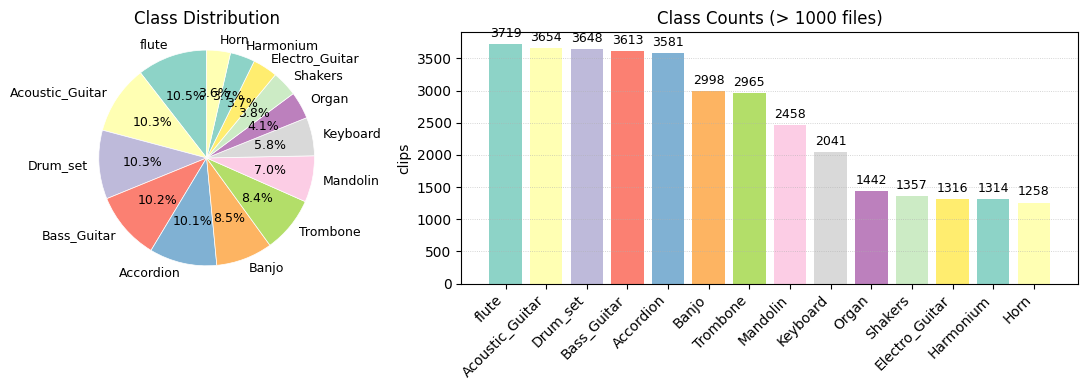

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# df_counts: ["class","count"] for classes > 1000
labels = df_counts["class"].tolist()
values = df_counts["count"].to_numpy()

# Palette for both charts
cmap = plt.get_cmap("Set3")
colors = [cmap(i % cmap.N) for i in range(len(labels))]

# Put pie chart at left and bar chart at right
fig, (ax_pie, ax_bar) = plt.subplots(
    1, 2, figsize=(11, 4),
    gridspec_kw={"width_ratios": [1, 2.6]}
)

# Pie to show proportion per class
wedges, texts, autotexts = ax_pie.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops={"linewidth": 0.5, "edgecolor": "white"},
    textprops={"fontsize": 9}
)
ax_pie.set_title("Class Distribution")
ax_pie.axis("equal")

# Bar to show absolute counts per class
x = np.arange(len(labels))
bars = ax_bar.bar(x, values, color=colors)
ax_bar.set_title("Class Counts (> 1000 files)")
ax_bar.set_ylabel("clips")
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(labels, rotation=45, ha="right")
ax_bar.bar_label(bars, labels=[str(v) for v in values], padding=3, fontsize=9)

# subtle grid for readability
ax_bar.grid(axis="y", linestyle=":", linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

Expand class folders into a file level table

In [8]:
# Make one row per audio file with its class
selected_classes = df_counts["class"].tolist()

rows = []
for c in selected_classes:
    # Collect only .wav files
    for p in (DATA_DIR / c).glob("*.wav"):
        rows.append({"file": p.name, "class": c})

df = pd.DataFrame(rows)

print(f"Rows: {len(df)}")
df.head()

Rows: 35364


file  class
0   947.wav  flute
1  3031.wav  flute
2  2616.wav  flute
3  2051.wav  flute
4   791.wav  flute

Read basic audio metadata

In [9]:
import numpy as np
import pandas as pd, soundfile as sf
from tqdm.auto import tqdm

# Helper function: path to the audio file for a dataframe row
def path_of(row):
    return str((DATA_DIR / row["class"] / row["file"]).resolve())

# Ensure metadata columns exist
for col in ["sr", "channels", "duration"]:
    if col not in df.columns:
        df[col] = pd.Series(np.nan, index=df.index, dtype="float64")

# Only process rows with no metadata fields
mask = df["sr"].isna() | df["duration"].isna() | df["channels"].isna()

unreadable_count = 0
for i, row in tqdm(df.loc[mask].iterrows(), total=int(mask.sum())):
    p = path_of(row)
    try:
        # Read only header so no need to load the whole audio into memory
        with sf.SoundFile(p) as f:
            sr = float(f.samplerate)
            ch = float(f.channels)
            dur = float(len(f) / f.samplerate)
        df.at[i, "sr"] = sr
        df.at[i, "channels"] = ch
        df.at[i, "duration"] = dur
    except Exception:
        # Count files that cannot be read
        unreadable_count += 1

print(f"Unreadable: {unreadable_count}")

  0%|          | 0/35364 [00:00<?, ?it/s]

Unreadable: 0


In [10]:
df.head()

file  class       sr  channels  duration
0   947.wav  flute  22050.0       1.0       3.0
1  3031.wav  flute  22050.0       1.0       3.0
2  2616.wav  flute  22050.0       1.0       3.0
3  2051.wav  flute  22050.0       1.0       3.0
4   791.wav  flute  22050.0       1.0       3.0

View audio files summary

In [11]:
display(df[['sr','channels','duration']].describe())

sr  channels  duration
count  35364.0   35364.0   35364.0
mean   22050.0       1.0       3.0
std        0.0       0.0       0.0
min    22050.0       1.0       3.0
25%    22050.0       1.0       3.0
50%    22050.0       1.0       3.0
75%    22050.0       1.0       3.0
max    22050.0       1.0       3.0

---

**Set feature and preprocessing constants**

Centralize audio settings used across the pipeline to keep tensors uniform and avoid unnecessary resampling

In [12]:
# Feature and processing settings

# Native sample rate to use throughout
sample_rate = 22050
# Fixed clip length so all tensors share the same time dimension
clip_seconds = 3.0
samples_per_clip = int(sample_rate * clip_seconds)

# STFT settings: 1024-point FFT (~46 ms at 22.05 kHz) balances time vs frequency detail
fft_size         = 1024
# Hop length (75% overlap is ~11.6 ms hop) gives smoother spectrograms and better transient capture
hop_length       = 256
# Mel-spectrogram resolution: 64 bins capture timbre detail without heavy compute
num_mel_bins     = 64
# MFCC dimensionality used for music/audio classification
num_mfcc         = 13

Play one sample per class

In [13]:
import numpy as np, librosa, soundfile as sf
from IPython.display import Audio, display
import ipywidgets as widgets

# one sample per class
one_per_class = (
    df.sort_values(["class", "file"])
      .groupby("class", sort=True)
      .nth(1)
)

def load_mono_fixed(path, sr=sample_rate, length=samples_per_clip):
    # Read audio as float32 and average to mono if stereo
    x, in_sr = sf.read(path, dtype="float32", always_2d=False)
    if x.ndim > 1: x = x.mean(axis=1)
    if in_sr != sr: x = librosa.resample(x, orig_sr=in_sr, target_sr=sr)
    return x[:length] if len(x) >= length else np.pad(x, (0, length - len(x)))

# build widgets for label + audio player per class
items = []
for _, row in one_per_class.iterrows():
    x = load_mono_fixed(path_of(row))
    label = widgets.Label(value=row["class"])
    out = widgets.Output()
    with out:
        display(Audio(x, rate=sample_rate))
    items.append(widgets.VBox([label, out]))

# grid layout to show
grid = widgets.GridBox(
    children=items,
    layout=widgets.Layout(
        grid_template_columns=f"repeat({3}, 1fr)",
        grid_gap="10px 12px",
        align_items="flex-start",
        width="100%"
    )
)

display(grid)

GridBox(children=(VBox(children=(Label(value='Accordion'), Output())), VBox(children=(Label(value='Acoustic_Gu…

Precompute diagnostic features

In [14]:
# Collect features for one sample per class
# Each entry stores raw clip + several time/frequency-domain features
features = []  # list of dicts: {"class","x","freqs","fft_mag","S_db","mel_db","mfcc","chroma"}

for _, row in one_per_class.iterrows():
    x = load_mono_fixed(path_of(row))

    # FFT (global frequency content)
    X = np.fft.rfft(x) # one-sided FFT for real signals
    freqs = np.fft.rfftfreq(len(x), d=1 / sample_rate) # frequency axis (Hz)
    fft_mag = np.abs(X) # magnitude spectrum

    # STFT (time–frequency)
    stft = librosa.stft(x, n_fft=fft_size, hop_length=hop_length)
    S_power = np.abs(stft)**2 # power spectrogram
    S_db = librosa.power_to_db(S_power, ref=np.max) # dB scale for visualization

    # Log-Mel spectrogram (perceptual frequency scale)
    mel = librosa.feature.melspectrogram(
        y=x, sr=sample_rate, n_fft=fft_size,
        hop_length=hop_length, n_mels=num_mel_bins, power=2.0
    )
    mel_db = librosa.power_to_db(mel, ref=np.max) 

    # MFCCs (compact timbre descriptor)
    mfcc = librosa.feature.mfcc(S=mel_db, n_mfcc=num_mfcc) # Using log-Mel (dB) as input to DCT for MFCCs

    # Chromagram (pitch class energy)
    chroma = librosa.feature.chroma_stft(S=np.abs(stft), sr=sample_rate)

    # Store result
    features.append({
        "class": row["class"], "x": x,
        "freqs": freqs, "fft_mag": fft_mag,
        "S_db": S_db, "mel_db": mel_db,
        "mfcc": mfcc, "chroma": chroma
    })

Plot waveforms

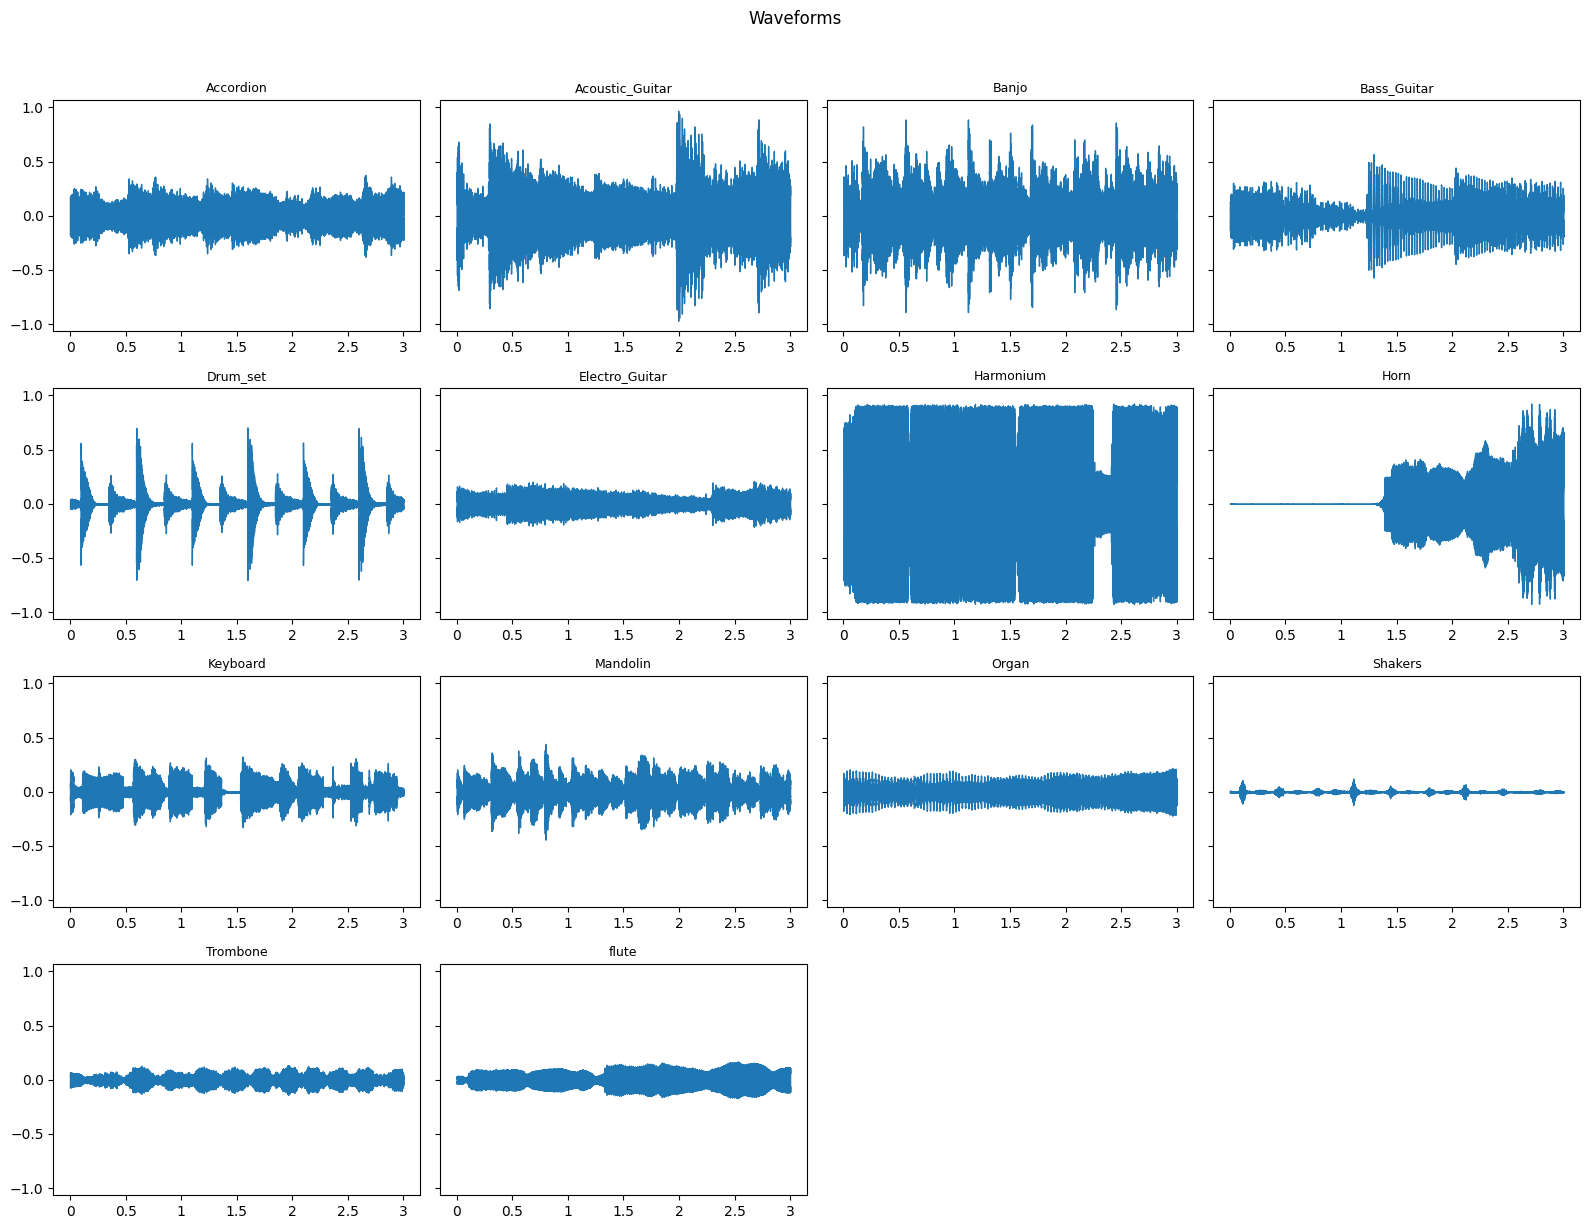

In [15]:
import math
import matplotlib.pyplot as plt

# 4 columns x enough rows to fit all classes
cols = 4
rows = math.ceil(len(features) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), sharey=True)
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    librosa.display.waveshow(f["x"], sr=sample_rate, ax=ax) # time-domain signal
    ax.set_title(f['class'], fontsize=9)
    ax.set_xlabel(""); ax.set_ylabel("")

for j in range(i+1, len(axes)): axes[j].axis("off")

fig.suptitle("Waveforms", y=1.02)
plt.tight_layout(); plt.show()

FFT magnitude (linear frequency)

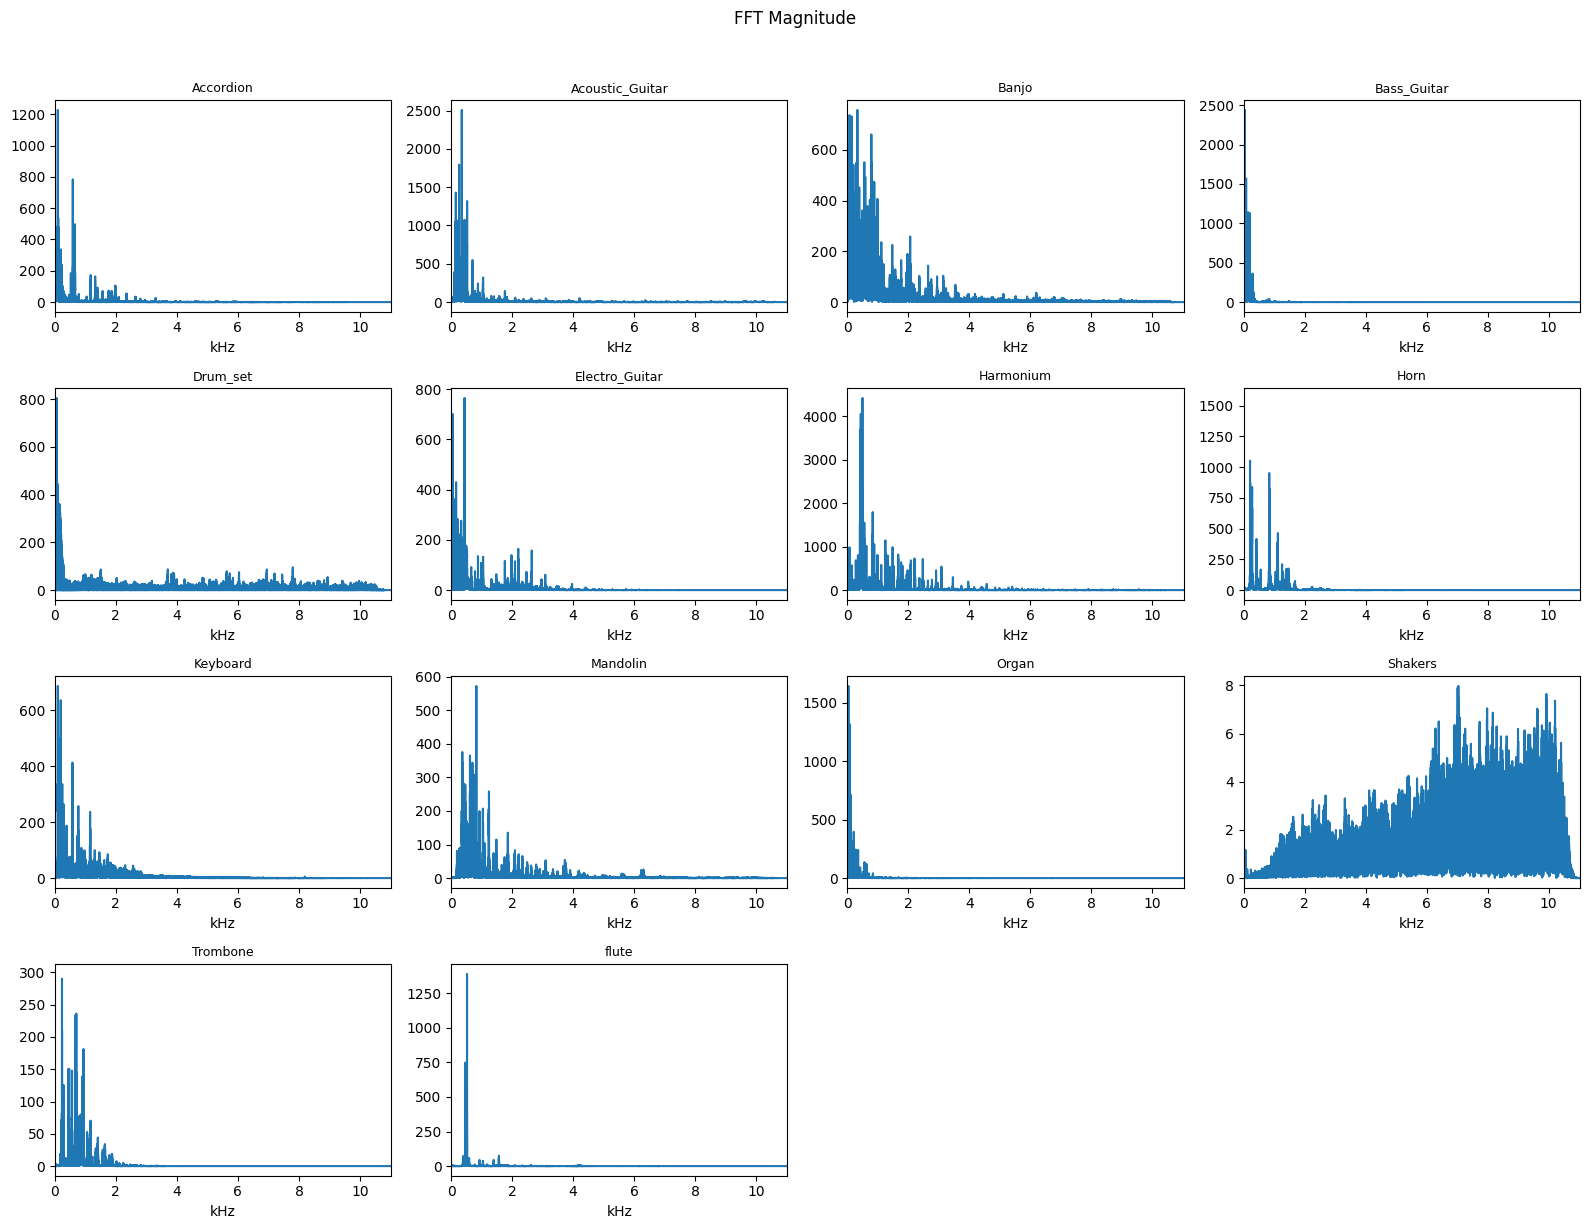

In [16]:
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    ax.plot(f["freqs"]/1000.0, f["fft_mag"]) # magnitude vs frequency (kHz)
    ax.set_title(f['class'], fontsize=9)
    ax.set_xlim(0, sample_rate/2000.0)  # show up to Nyquist (sr/2) in kHz
    ax.set_xlabel("kHz"); ax.set_ylabel("")

for j in range(i+1, len(axes)): axes[j].axis("off")

fig.suptitle("FFT Magnitude", y=1.02)
plt.tight_layout(); plt.show()

STFT Spectrogram (power in dB)

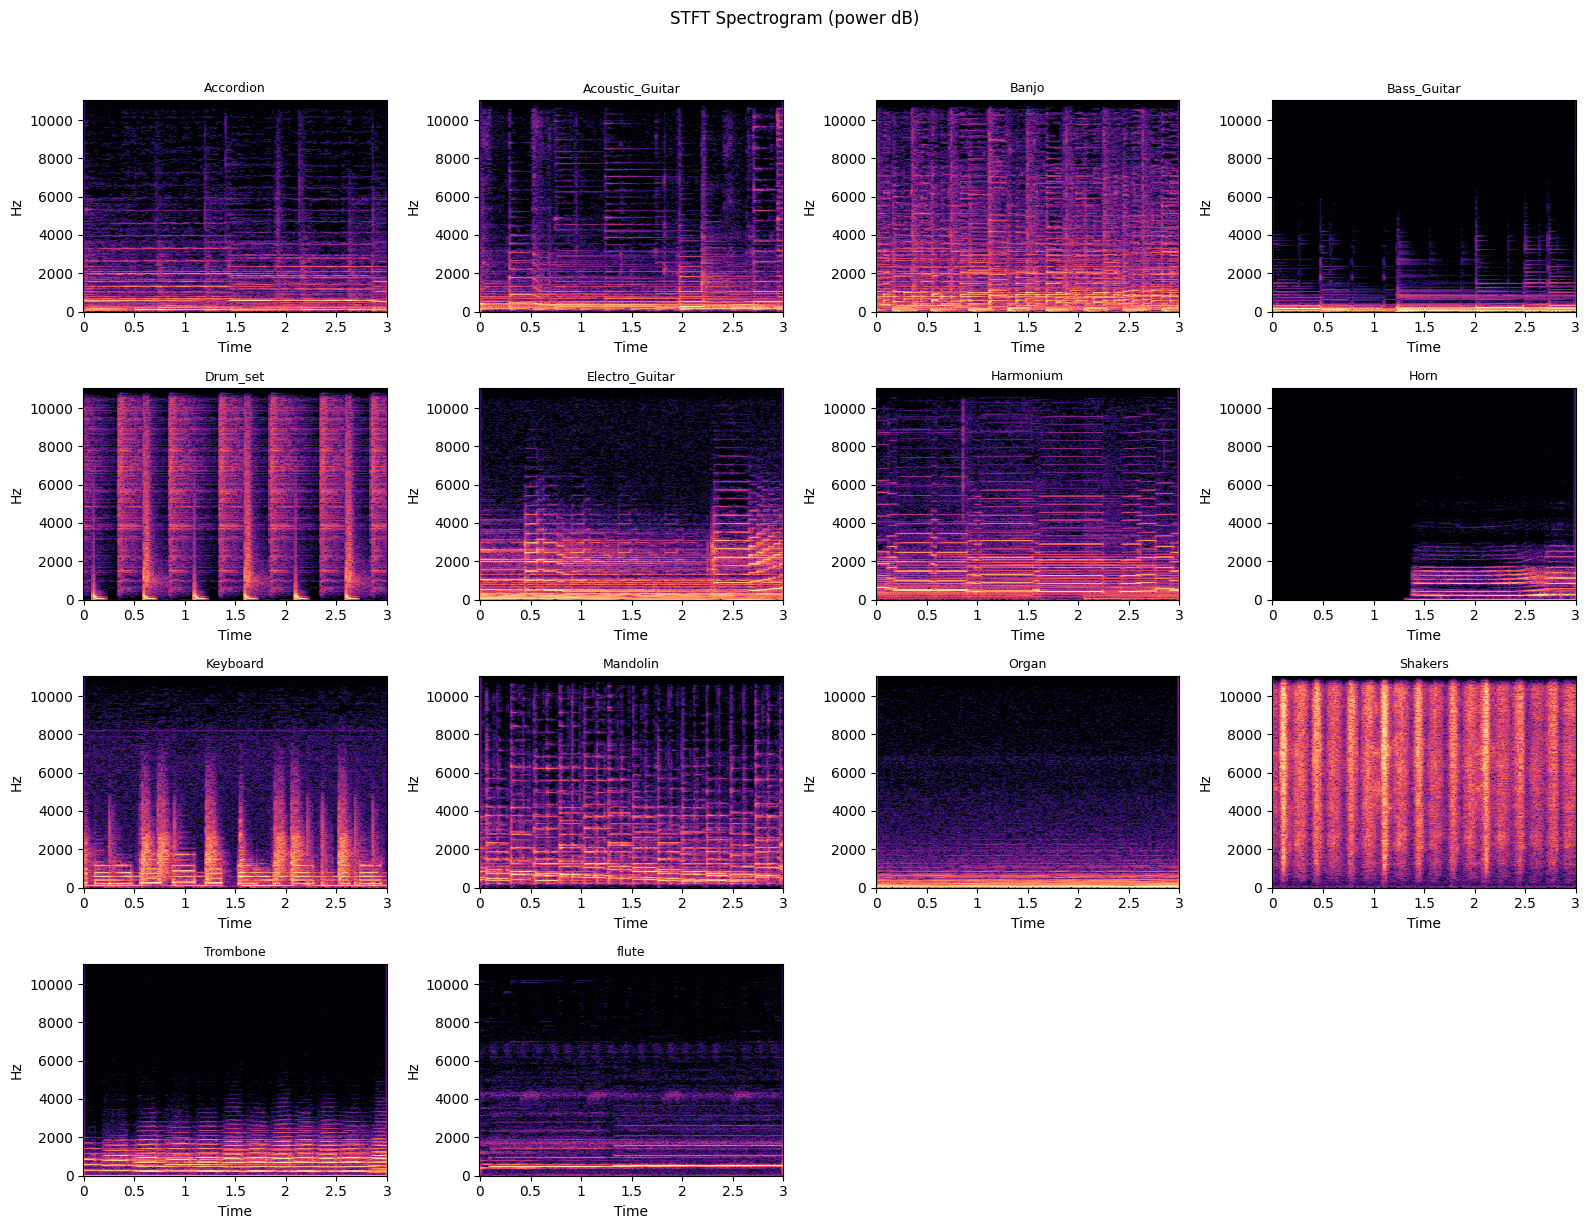

In [17]:
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    librosa.display.specshow(
        f["S_db"], # power spectrogram in dB
        sr=sample_rate, 
        hop_length=hop_length,
        x_axis="time", # time on x-axis
        y_axis="linear", # linear frequency on y-axis
        ax=ax)
    ax.set_title(f['class'], fontsize=9)

for j in range(i+1, len(axes)): axes[j].axis("off")

fig.suptitle("STFT Spectrogram (power dB)", y=1.02)
plt.tight_layout(); plt.show()

Mel Filterbank Matrix

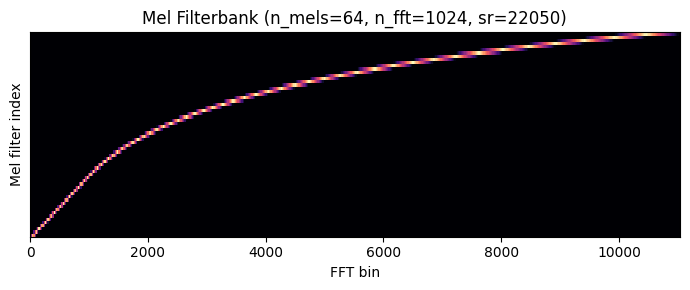

In [18]:
# maps linear FFT bins to Mel bands
mel_filterbank = librosa.filters.mel(
    sr=sample_rate, 
    n_fft=fft_size, 
    n_mels=num_mel_bins, 
    norm=None)

plt.figure(figsize=(7, 3))
librosa.display.specshow(mel_filterbank, x_axis="linear", y_axis=None)

plt.title(f"Mel Filterbank (n_mels={num_mel_bins}, n_fft={fft_size}, sr={sample_rate})")
plt.xlabel("FFT bin"); plt.ylabel("Mel filter index")
plt.tight_layout()
plt.show()

Mel-spaced filterbank (triangular filters over frequency)

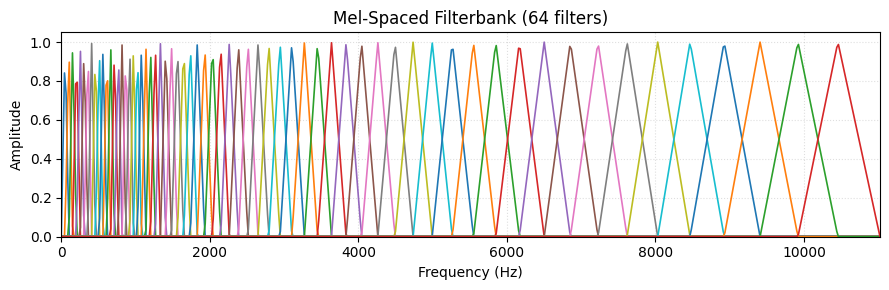

In [19]:
# Frequency (Hz) for each FFT bin up to Nyquist
fft_bin_hz = np.linspace(0, sample_rate/2, 1 + fft_size//2)

plt.figure(figsize=(9,3))

# Draw each Mel filter response (rows of the filterbank)
for i in range(num_mel_bins):
    plt.plot(fft_bin_hz, mel_filterbank[i], lw=1.2)

plt.title(f"Mel-Spaced Filterbank ({num_mel_bins} filters)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("Amplitude")
plt.ylim(0, 1.05)
plt.xlim(0, sample_rate/2) # 0 to Nyquist
plt.grid(ls=":", alpha=0.4)
plt.tight_layout()
plt.show()

Log-Mel Spectrogram (dB)

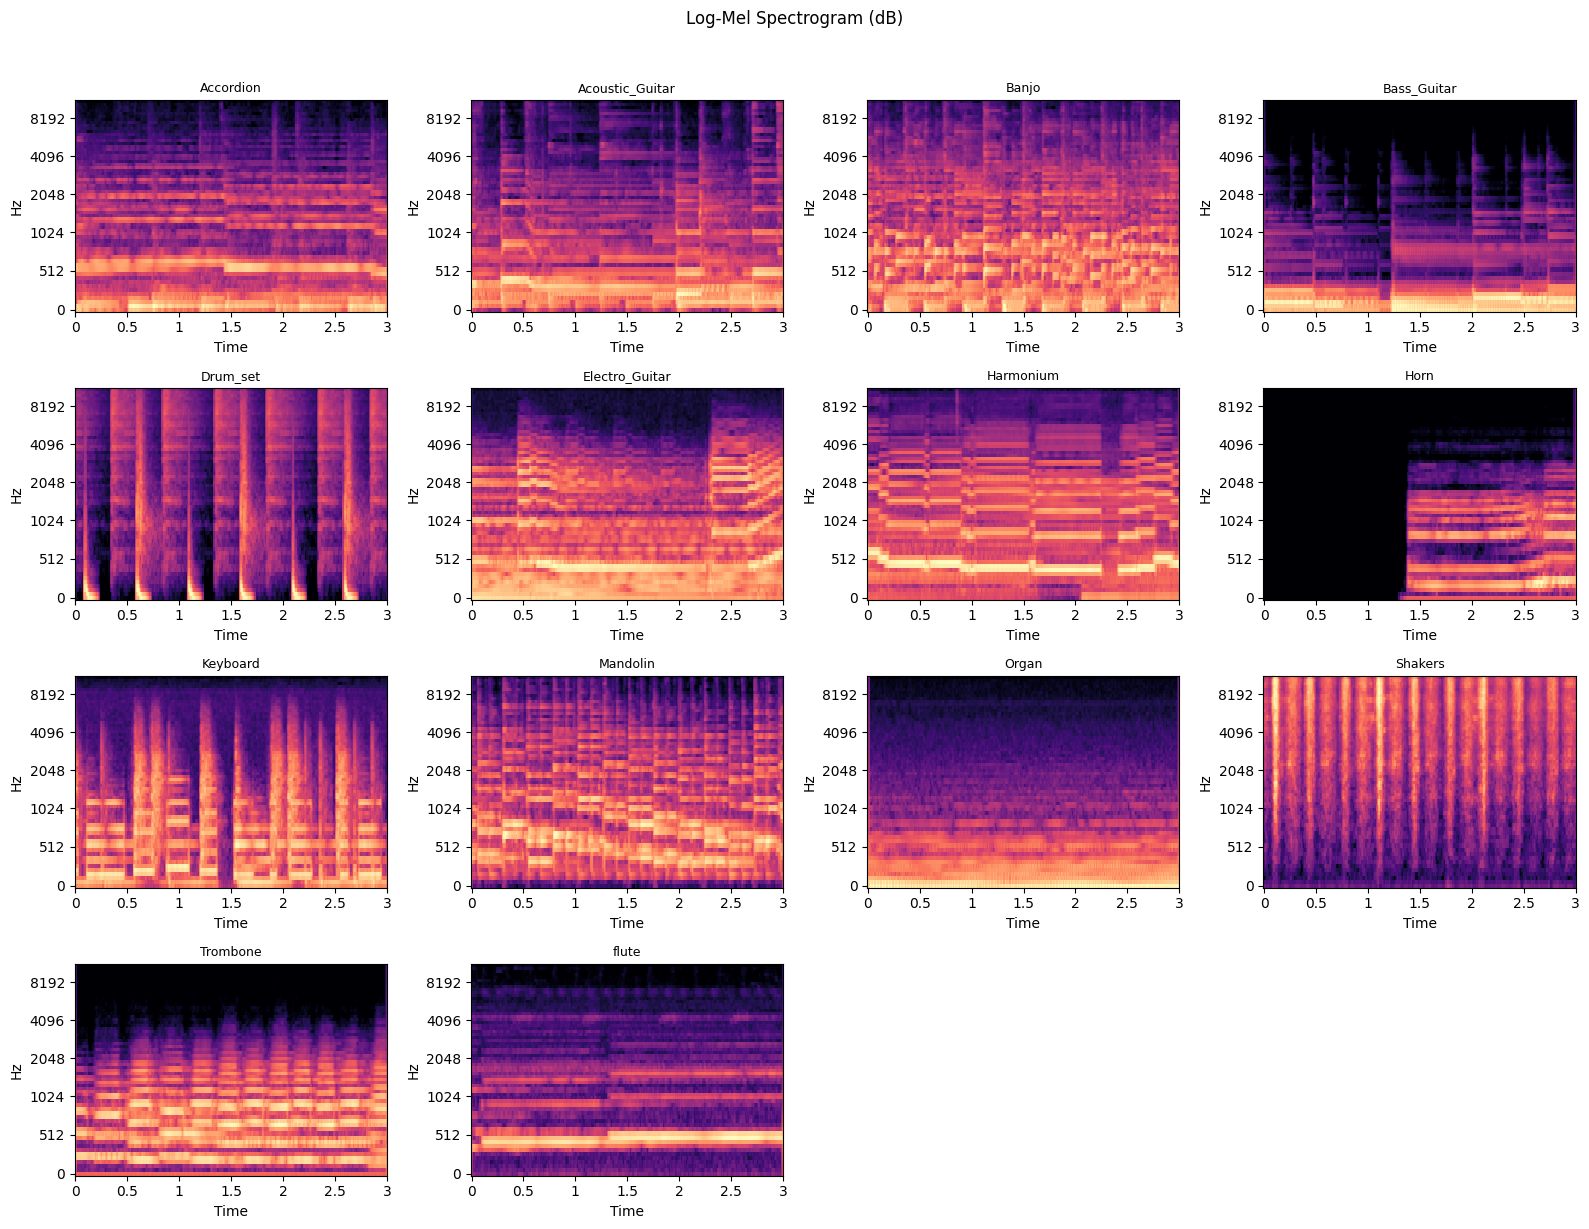

In [20]:
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    librosa.display.specshow(
        f["mel_db"], # log-Mel in dB
        sr=sample_rate,
        hop_length=hop_length,
        x_axis="time", # time on x-axis
        y_axis="mel", # Mel frequency on y-axis
        ax=ax
    )
    ax.set_title(f['class'], fontsize=9)
    
for j in range(i+1, len(axes)): axes[j].axis("off")

fig.suptitle("Log-Mel Spectrogram (dB)", y=1.02)
plt.tight_layout(); plt.show()

MFCCs

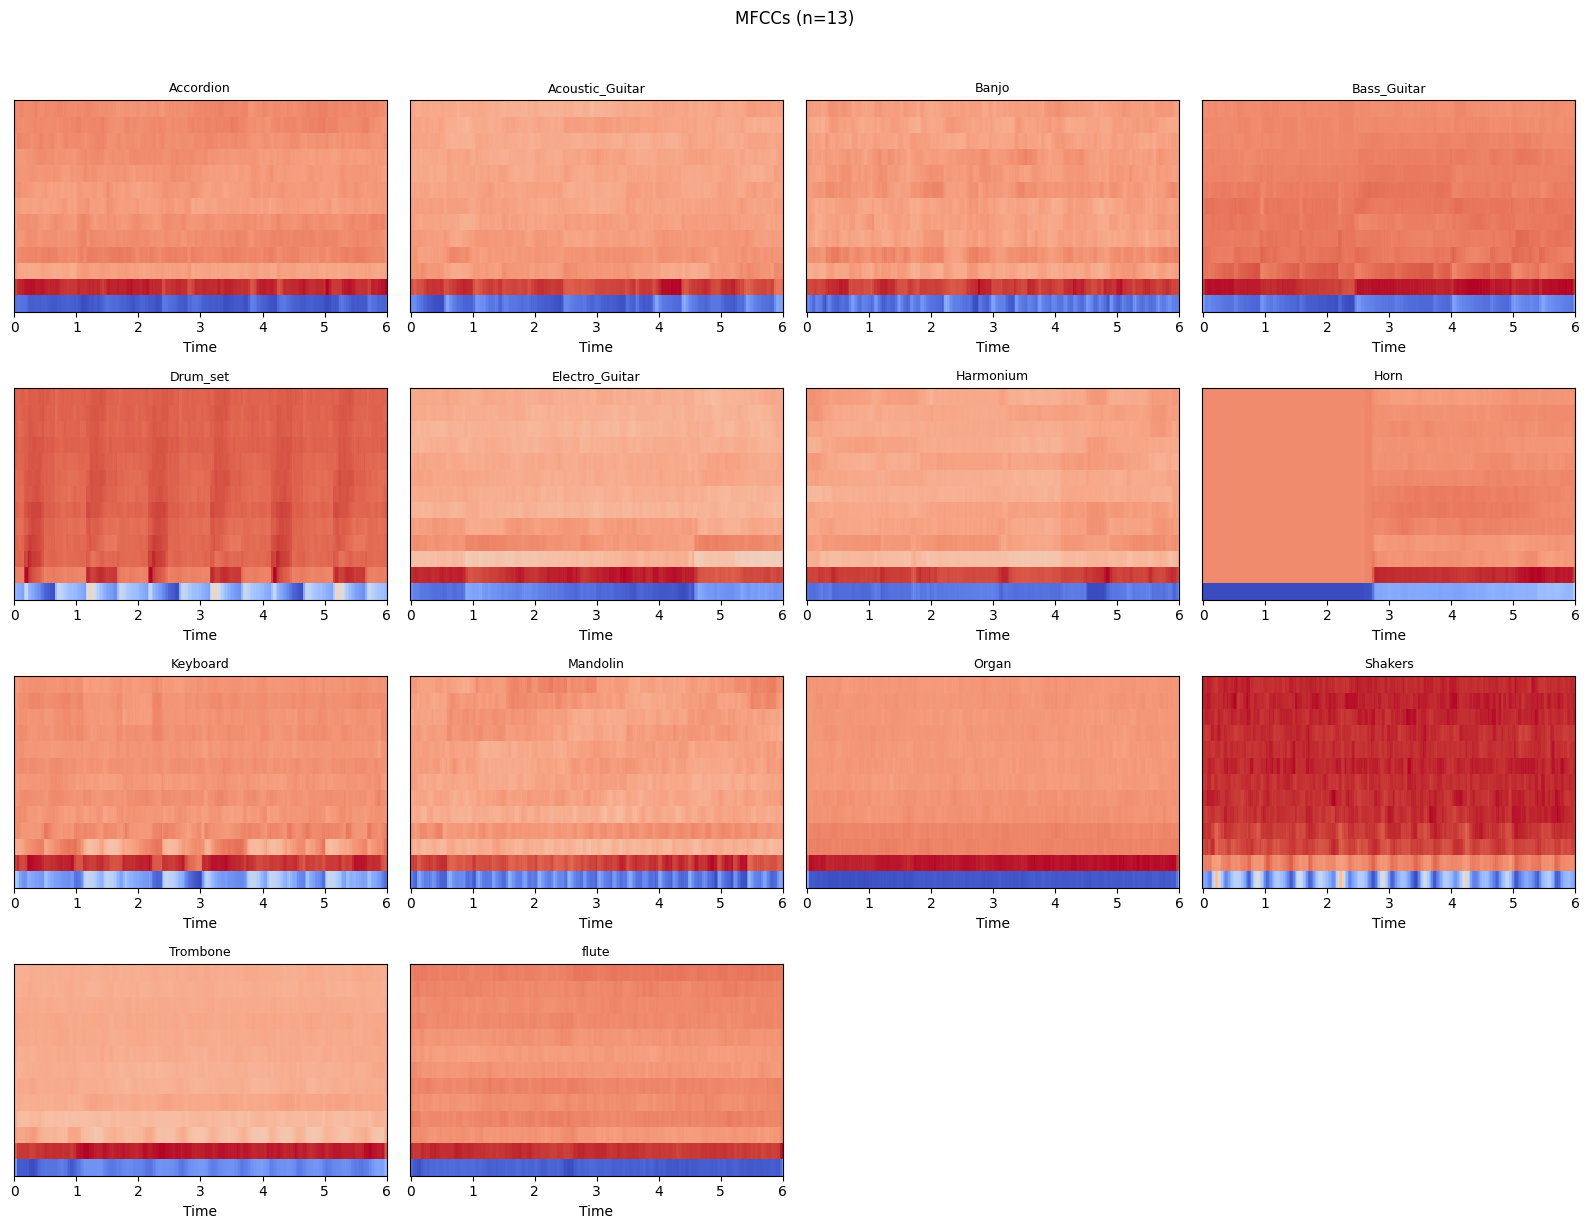

In [21]:
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    # MFCC matrix over time (coefficients on y-axis, time on x-axis)
    librosa.display.specshow(
        f["mfcc"],
        x_axis="time", 
        ax=ax)
    ax.set_title(f['class'], fontsize=9)

for j in range(i+1, len(axes)): axes[j].axis("off")

fig.suptitle(f"MFCCs (n={num_mfcc})", y=1.02)
plt.tight_layout(); plt.show()

Filter-bank coefficients (mean over time)

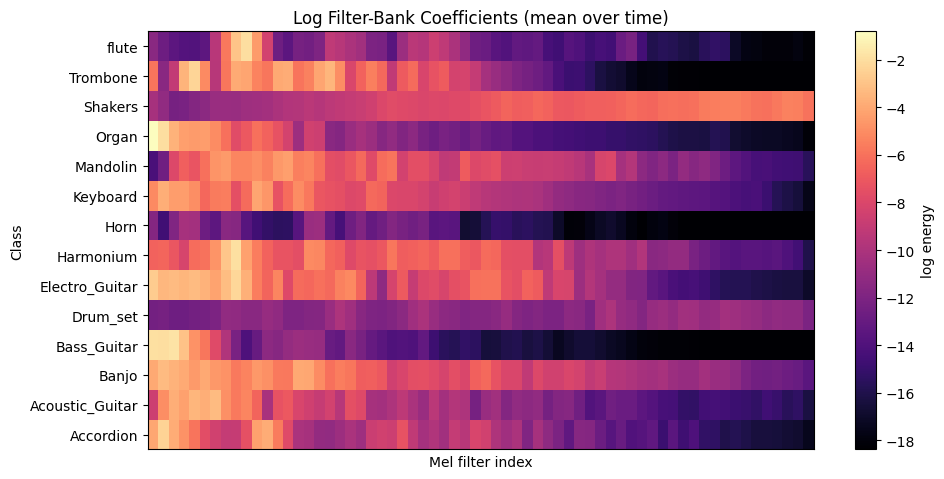

In [22]:
# Compute time-averaged log-Mel energies for each class sample
# Result: one vector of length num_mel_bins per class

# time-average log-mel per class to length become num_mel_bins
rows_list = []
for f in features:
    coeff = np.log(librosa.db_to_power(f["mel_db"]) + 1e-10).mean(axis=1)  # log energies
    rows_list.append({"class": f["class"], "coeff": coeff})

fbank_df = pd.DataFrame({
    "class": [r["class"] for r in rows_list],
    **{f"fb_{i}": [r["coeff"][i] for r in rows_list] for i in range(num_mel_bins)}
}).set_index("class")

# Heatmap: classes vs. Mel filter index
plt.figure(figsize=(10, max(4, 0.35*len(fbank_df))))
librosa.display.specshow(fbank_df.values, cmap="magma")
plt.title("Log Filter-Bank Coefficients (mean over time)")
plt.xlabel("Mel filter index")
plt.ylabel("Class")
plt.yticks(range(len(fbank_df.index)), fbank_df.index)
plt.colorbar(label="log energy")
plt.tight_layout()
plt.show()

---

Stratified train/val/test split (70/15/15)

In [23]:
from sklearn.model_selection import train_test_split

# build absolute paths once for convenience
df_all = df.copy()
df_all["path"] = df_all.apply(lambda r: str((DATA_DIR / r["class"] / r["file"]).resolve()), axis=1)

# Take 15% for final testing
trainval_df, test_df = train_test_split(
    df_all, test_size=0.15, stratify=df_all["class"], random_state=42
)

# From the remaining 85%, take 15/85 ≈ 17.647% as validation
# Resulting overall split ≈ 70% train / 15% val / 15% test
train_df, val_df = train_test_split(
    trainval_df, test_size=0.17647, stratify=trainval_df["class"], random_state=42
)

In [24]:
# Build a table of per-class counts for each split
count_tbl = pd.DataFrame({
    "Train": train_df["class"].value_counts(),
    "Val":   val_df["class"].value_counts(),
    "Test":  test_df["class"].value_counts(),
}).fillna(0).astype(int).sort_index()

# add row total
count_tbl["Total"] = count_tbl.sum(axis=1)
count_tbl.loc["Total"] = count_tbl.sum(axis=0)

display(count_tbl)

Train   Val  Test  Total
class                                    
Accordion         2507   537   537   3581
Acoustic_Guitar   2558   548   548   3654
Banjo             2098   450   450   2998
Bass_Guitar       2529   542   542   3613
Drum_set          2554   547   547   3648
Electro_Guitar     922   197   197   1316
Harmonium          920   197   197   1314
Horn               880   189   189   1258
Keyboard          1429   306   306   2041
Mandolin          1720   369   369   2458
Organ             1010   216   216   1442
Shakers            949   204   204   1357
Trombone          2075   445   445   2965
flute             2603   558   558   3719
Total            24754  5305  5305  35364

Class index mapping

In [25]:
# Sorted list of class names (stable order across runs)
class_names = sorted(train_df["class"].unique().tolist())

# Map: class name to integer index (0..num_classes-1)
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Number of target classes
num_classes = len(class_names)

TF log-Mel feature pipeline with tf.data loaders

In [26]:
# Mel frequency range (Hz)
fmin, fmax = 0.0, sample_rate/2

# Precompute Mel weight matrix once for TF ops (linear FFT bins to Mel bins)
mel_w = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins,
    1 + fft_size // 2,
    sample_rate,
    lower_edge_hertz=fmin,
    upper_edge_hertz=fmax,
    dtype=tf.float32,
)

def wav_to_logmel(path: tf.Tensor) -> tf.Tensor:
    # Read WAV file and decode to mono tensor
    audio_bin = tf.io.read_file(path)
    x, sr = tf.audio.decode_wav(audio_bin, desired_channels=1) # x: [T, 1], sr: scalar
    x = tf.squeeze(tf.cast(x, tf.float32), axis=-1) # [T]

    # STFT to power spectrogram
    S = tf.signal.stft(x, frame_length=fft_size, frame_step=hop_length, fft_length=fft_size)
    P = tf.math.real(S * tf.math.conj(S)) # [frames, 1+fft/2]

    # Linear to Mel, then take log for dynamic range compression
    M = tf.matmul(P, mel_w) # [frames, n_mels]
    M = tf.math.log(M + 1e-6) # log-Mel

    # Shape to [mels, frames, 1] for CNNs; ensure known mel dim for Keras
    M = tf.transpose(M, perm=[1, 0])[:, :, tf.newaxis]
    M = tf.ensure_shape(M, [num_mel_bins, None, 1]) # helpful for Keras shape inference
    return M

def make_ds_simple(dframe, batch=32, training=False, shuffle=1000):
    # Prepare file paths and integer labels
    paths  = dframe["path"].astype(str).tolist()
    labels = dframe["class"].map(class_to_idx).astype(np.int32).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(shuffle, reshuffle_each_iteration=True)  # randomise batches during training

    # Map WAV to log-Mel tensor
    def _map(p, y):
        M = wav_to_logmel(p)                           # [mels, frames, 1]
        return tf.cast(M, tf.float32), tf.cast(y, tf.int32)

    # Parallel map, pad variable time axis, and prefetch for throughput
    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.padded_batch(batch, padded_shapes=([num_mel_bins, None, 1], []))
    return ds.prefetch(tf.data.AUTOTUNE)
    
# Build datasets
train_ds = make_ds_simple(train_df, batch=32, training=True)
val_ds   = make_ds_simple(val_df,   batch=32, training=False)
test_ds  = make_ds_simple(test_df,  batch=32, training=False)

I0000 00:00:1759587565.164038   24732 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Define Evaluation Method to Make life easier

training curves, predictions, confusion matrix and classification report

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def plot_training_curves(history, metrics=("loss", "accuracy"), figsize=(10, 4), suptitle=None):
    # Handle Training History
    hist = history.history if hasattr(history, "history") else history

    # Plot metrics that have both train and val series
    show_metrics = [m for m in metrics if (m in hist and f"val_{m}" in hist)]
    if not show_metrics:
        # Fallback: try common keys
        keys = list(hist.keys())
        show_metrics = [k for k in ("loss", "accuracy") if k in keys and f"val_{k}" in keys]

    n = max(1, len(show_metrics))
    fig, axes = plt.subplots(1, n, figsize=figsize)
    axes = np.atleast_1d(axes)

    # Plot metrics
    for ax, m in zip(axes, show_metrics):
        ax.plot(hist[m], label="train")
        ax.plot(hist[f"val_{m}"], label="val")
        ax.set_title(m.capitalize())
        ax.set_xlabel("Epoch")
        ax.legend()

    if suptitle:
        fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

def batch_predict(ds, model):
    # Iterate over a tf.data dataset and collect true/pred labels
    y_true, y_pred = [], []
    for X, y in ds:
        # If labels are one-hot, convert to integer indices
        y_np = y.numpy()
        if y_np.ndim > 1 and y_np.shape[-1] > 1:
            y_labels = np.argmax(y_np, axis=1)
        else:
            y_labels = y_np.reshape(-1)

        # Model forward pass
        p = model.predict(X, verbose=0)
        y_true.extend(y_labels.tolist())
        y_pred.extend(np.argmax(p, axis=1).tolist())
    return np.asarray(y_true, dtype=int), np.asarray(y_pred, dtype=int)

def plot_confusion(cm, class_names=None, normalize=False, cmap="Blues",
                   title="Confusion Matrix", xtick_rotation=45, ytick_rotation=0):
    # Row-normalize the confusion matrix to show per-class accuracy
    if normalize:
        with np.errstate(all="ignore"):
            cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    # Display plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=cmap, values_format=".2f" if normalize else "d", colorbar=False)

    ax = plt.gca()
    ax.set_title(title)

    # Rotate ticks for readability
    for label in ax.get_xticklabels():
        label.set_rotation(xtick_rotation)
        label.set_horizontalalignment("right")
    for label in ax.get_yticklabels():
        label.set_rotation(ytick_rotation)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_ds, class_names=None, model_name="Model", normalize_cm=False, num_classes=None, return_results=True):
    # Run predictions and gather ground-truth labels
    y_true, y_pred = batch_predict(test_ds, model)

    # Ensure confusion_matrix uses the full label set
    if num_classes is None:
        if class_names is not None:
            num_classes = len(class_names)
        else:
            num_classes = int(max(y_true.max(), y_pred.max())) + 1
    labels = np.arange(num_classes)

    # Overall accuracy
    acc = (y_true == y_pred).mean()
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"{model_name} Test accuracy: {acc:.4f}")

    # Confusion matrix plot
    title = f"{model_name} - Confusion Matrix"
    plot_confusion(cm, class_names=class_names, normalize=normalize_cm, title=title)

    # Classification report
    names_for_report = class_names if class_names is not None else [str(i) for i in labels]
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=names_for_report, digits=3))

    # Can return raw results for further analysis
    if return_results:
        return {
            "y_true": y_true,
            "y_pred": y_pred,
            "accuracy": acc,
            "confusion_matrix": cm
        }

---

**Build the Baseline CNN Model**

simple conv net on log-Mel,
validate the data pipeline before trying deeper models

In [28]:
from tensorflow.keras import Sequential, layers, optimizers

# Log-Mel input: [mels, frames, channels]
input_shape = (num_mel_bins, None, 1)

base_model_cnn = Sequential(name="base_model_cnn")
base_model_cnn.add(layers.Input(shape=(num_mel_bins, None, 1)))

# Block 1
base_model_cnn.add(layers.Conv2D(8, (3,3), padding="same", activation="relu"))
base_model_cnn.add(layers.MaxPooling2D(pool_size=(4,4)))

# Block 2
base_model_cnn.add(layers.Conv2D(8, (3,3), padding="same", activation="relu"))
base_model_cnn.add(layers.MaxPooling2D(pool_size=(4,4)))

# Classification head
base_model_cnn.add(layers.GlobalAveragePooling2D()) # reduce HxW to 1x1
base_model_cnn.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

# Compile with a simple optimizer and standard loss for int labels
base_model_cnn.compile(
    optimizer=optimizers.SGD(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

base_model_cnn.summary()

Model: "base_model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, None, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, None, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, None, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, None, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790 (3.09 KB)

 Trainable params: 790 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

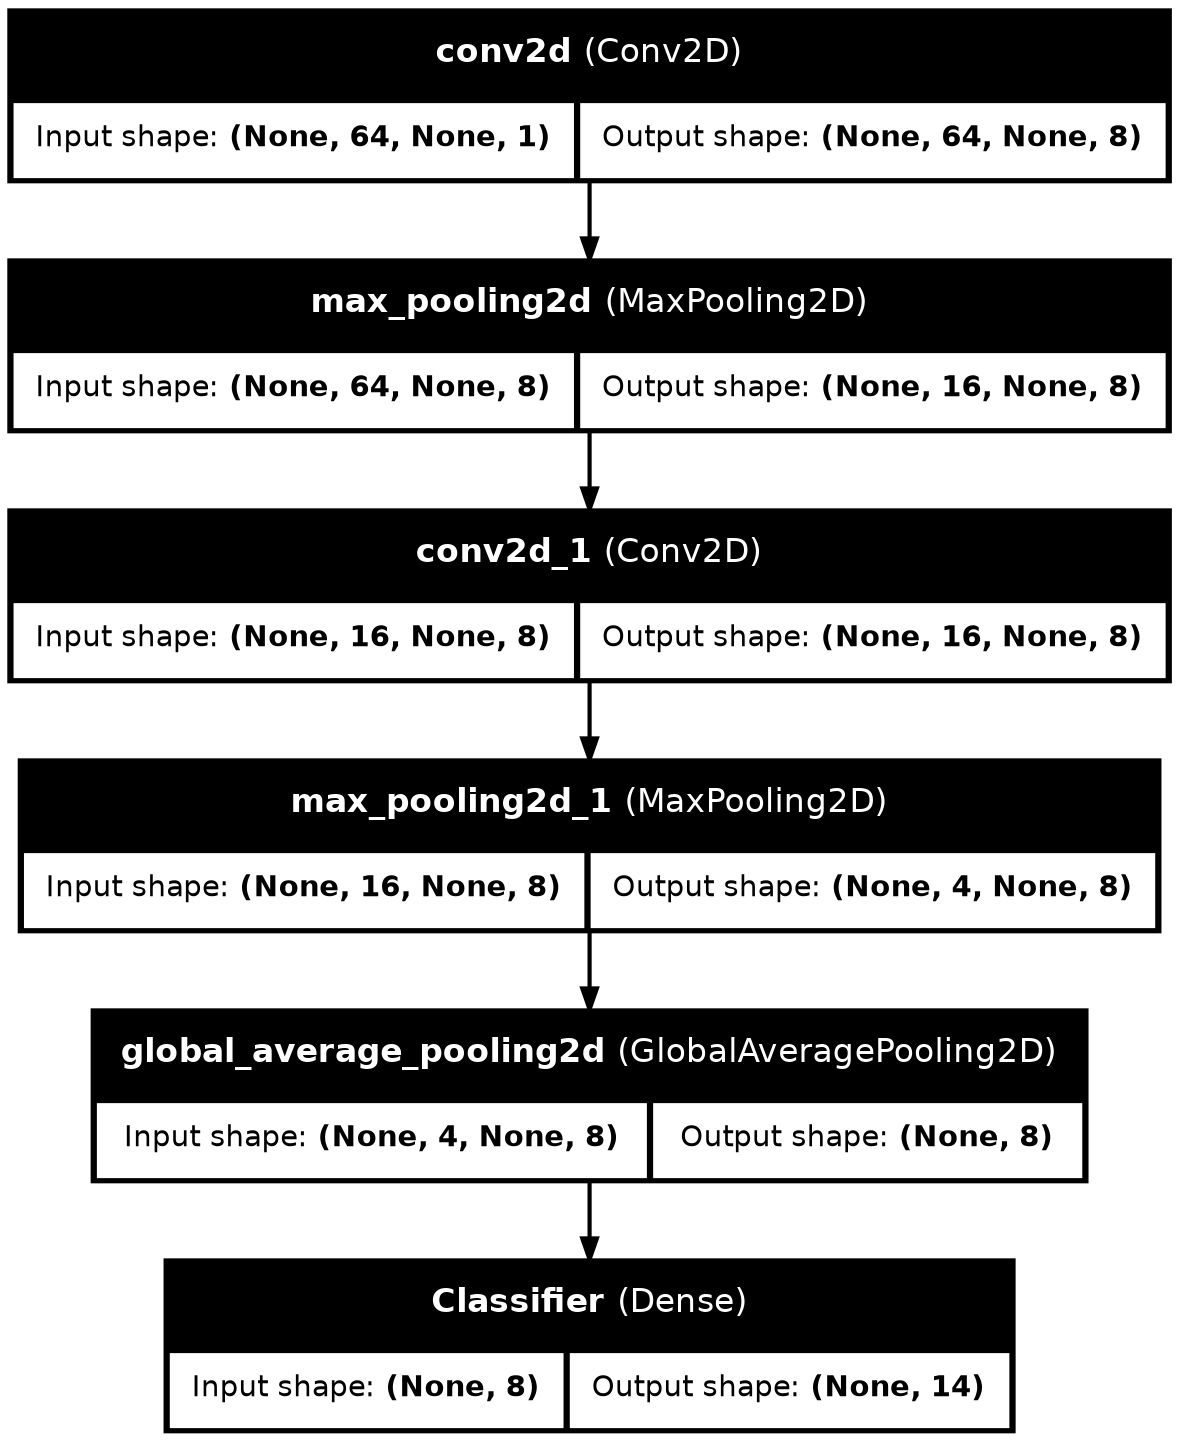

In [30]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(base_model_cnn, to_file="../output/model_architecture/base_model_cnn.png",
           show_shapes=True, show_layer_names=True,
           expand_nested=True, dpi=150)
display(Image(filename="../output/model_architecture/base_model_cnn.png", width=450))

Train the Baseline CNN

In [ ]:
from tensorflow.keras import callbacks

# Log epoch-by-epoch metrics to save the footprint
log = callbacks.CSVLogger("../output/training_log/base_model_cnn.csv", append=False)

# Train baseline model on log-Mel inputs
history = base_model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=log,
    verbose=1
)

Epoch 1/30


2025-09-25 14:13:26.277222: I external/local_xla/xla/service/service.cc:163] XLA service 0x7a3e5c004580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-25 14:13:26.277265: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-09-25 14:13:26.351728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-25 14:13:26.540562: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


 19/774 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.0486 - loss: 3.0003     

I0000 00:00:1758780811.404415   49015 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


774/774 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.4072 - loss: 1.8161 - val_accuracy: 0.5874 - val_loss: 1.3150
Epoch 2/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7098 - loss: 0.9458 - val_accuracy: 0.7877 - val_loss: 0.6965
Epoch 3/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7795 - loss: 0.7054 - val_accuracy: 0.8136 - val_loss: 0.6085
Epoch 4/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8013 - loss: 0.6153 - val_accuracy: 0.7749 - val_loss: 0.6174
Epoch 5/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8233 - loss: 0.5425 - val_accuracy: 0.7813 - val_loss: 0.6489
Epoch 6/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8367 - loss: 0.4999 - val_accuracy: 0.8511 - val_loss: 0.4622
Epoch 7/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8444 - loss: 0.4670 - val_accuracy: 0.8392 - val_loss: 0.4637
Epoch 8/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8518 - loss: 0.4453 - val_accuracy: 0.

Evaluate Baseline CNN Model

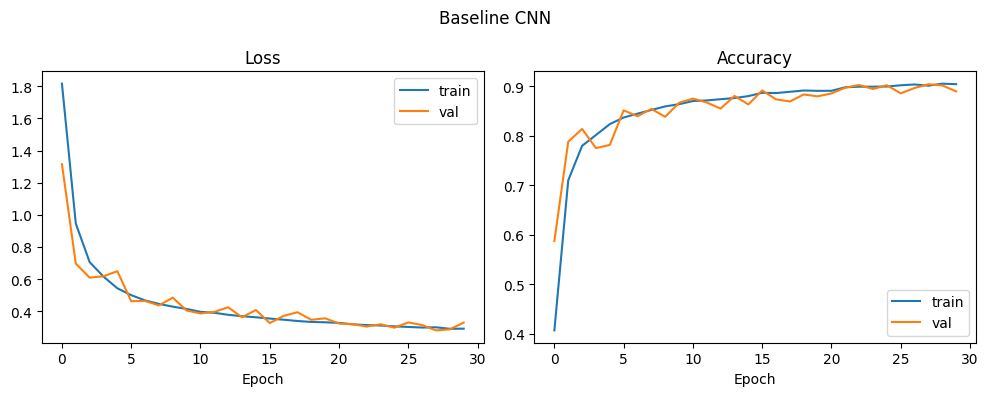

In [ ]:
# Plot training curves
plot_training_curves(history, metrics=("loss", "accuracy"), suptitle="Baseline CNN")

2025-09-25 14:20:05.066541: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Baseline CNN Test accuracy: 0.8854


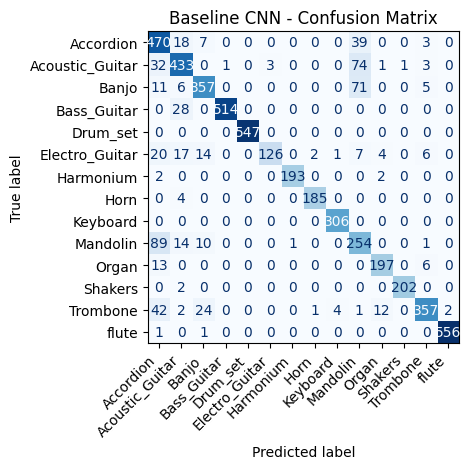


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.691     0.875     0.772       537
Acoustic_Guitar      0.826     0.790     0.808       548
          Banjo      0.864     0.793     0.827       450
    Bass_Guitar      0.998     0.948     0.973       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.977     0.640     0.773       197
      Harmonium      0.995     0.980     0.987       197
           Horn      0.984     0.979     0.981       189
       Keyboard      0.984     1.000     0.992       306
       Mandolin      0.570     0.688     0.623       369
          Organ      0.912     0.912     0.912       216
        Shakers      0.995     0.990     0.993       204
       Trombone      0.937     0.802     0.864       445
          flute      0.996     0.996     0.996       558

       accuracy                          0.885      5305
      macro avg      0.909     0.885     0.893      5305
   w

In [ ]:
# Evaluate model, and plot confusion matrix and classification report
results = evaluate_model(
    model=base_model_cnn,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Baseline CNN",
    normalize_cm=False
)

In [ ]:
# Save model
base_model_cnn.save("../output/model/base_model_cnn.keras")

---

**Enhanced CNN**

BN, deeper conv blocks, and dropout

improve feature learning and generalization over the baseline

In [ ]:
from tensorflow.keras import Sequential, layers, optimizers

# Log-Mel input: [mels, frames, channels]
input_shape = (num_mel_bins, None, 1)

enhanced_model_cnn = Sequential(name="enhanced_model_cnn")
enhanced_model_cnn.add(layers.Input(shape=input_shape))

# Block 1
enhanced_model_cnn.add(layers.Conv2D(8, (3,3), padding="same")) # conv without inline activation
enhanced_model_cnn.add(layers.BatchNormalization())               # stabilize/accelerate training
enhanced_model_cnn.add(layers.ReLU())                             # non-linearity after BN
enhanced_model_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))      # downsample (time x mel)

# Block 2
enhanced_model_cnn.add(layers.Conv2D(16, (3,3), padding="same"))
enhanced_model_cnn.add(layers.BatchNormalization())
enhanced_model_cnn.add(layers.ReLU())
enhanced_model_cnn.add(layers.MaxPooling2D(pool_size=(2,2)))

# Block 3
enhanced_model_cnn.add(layers.Conv2D(32, (3,3), padding="same"))
enhanced_model_cnn.add(layers.BatchNormalization())
enhanced_model_cnn.add(layers.ReLU())
enhanced_model_cnn.add(layers.Dropout(0.3))                       # regularize features

# Classification head
enhanced_model_cnn.add(layers.GlobalAveragePooling2D())           # squeeze spatial dims
enhanced_model_cnn.add(layers.Dense(32, activation="relu"))       # small dense bottleneck
enhanced_model_cnn.add(layers.Dropout(0.3))                       # regularize head
enhanced_model_cnn.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

# Compile with Adam and standard sparse CE for integer labels
enhanced_model_cnn.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

enhanced_model_cnn.summary()

Model: "enhanced_model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, None, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, None, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, None, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, None, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, None, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, None, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, None, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, None, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, None, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, None, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, None, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,630 (29.80 KB)

 Trainable params: 7,518 (29.37 KB)

 Non-trainable params: 112 (448.00 B)

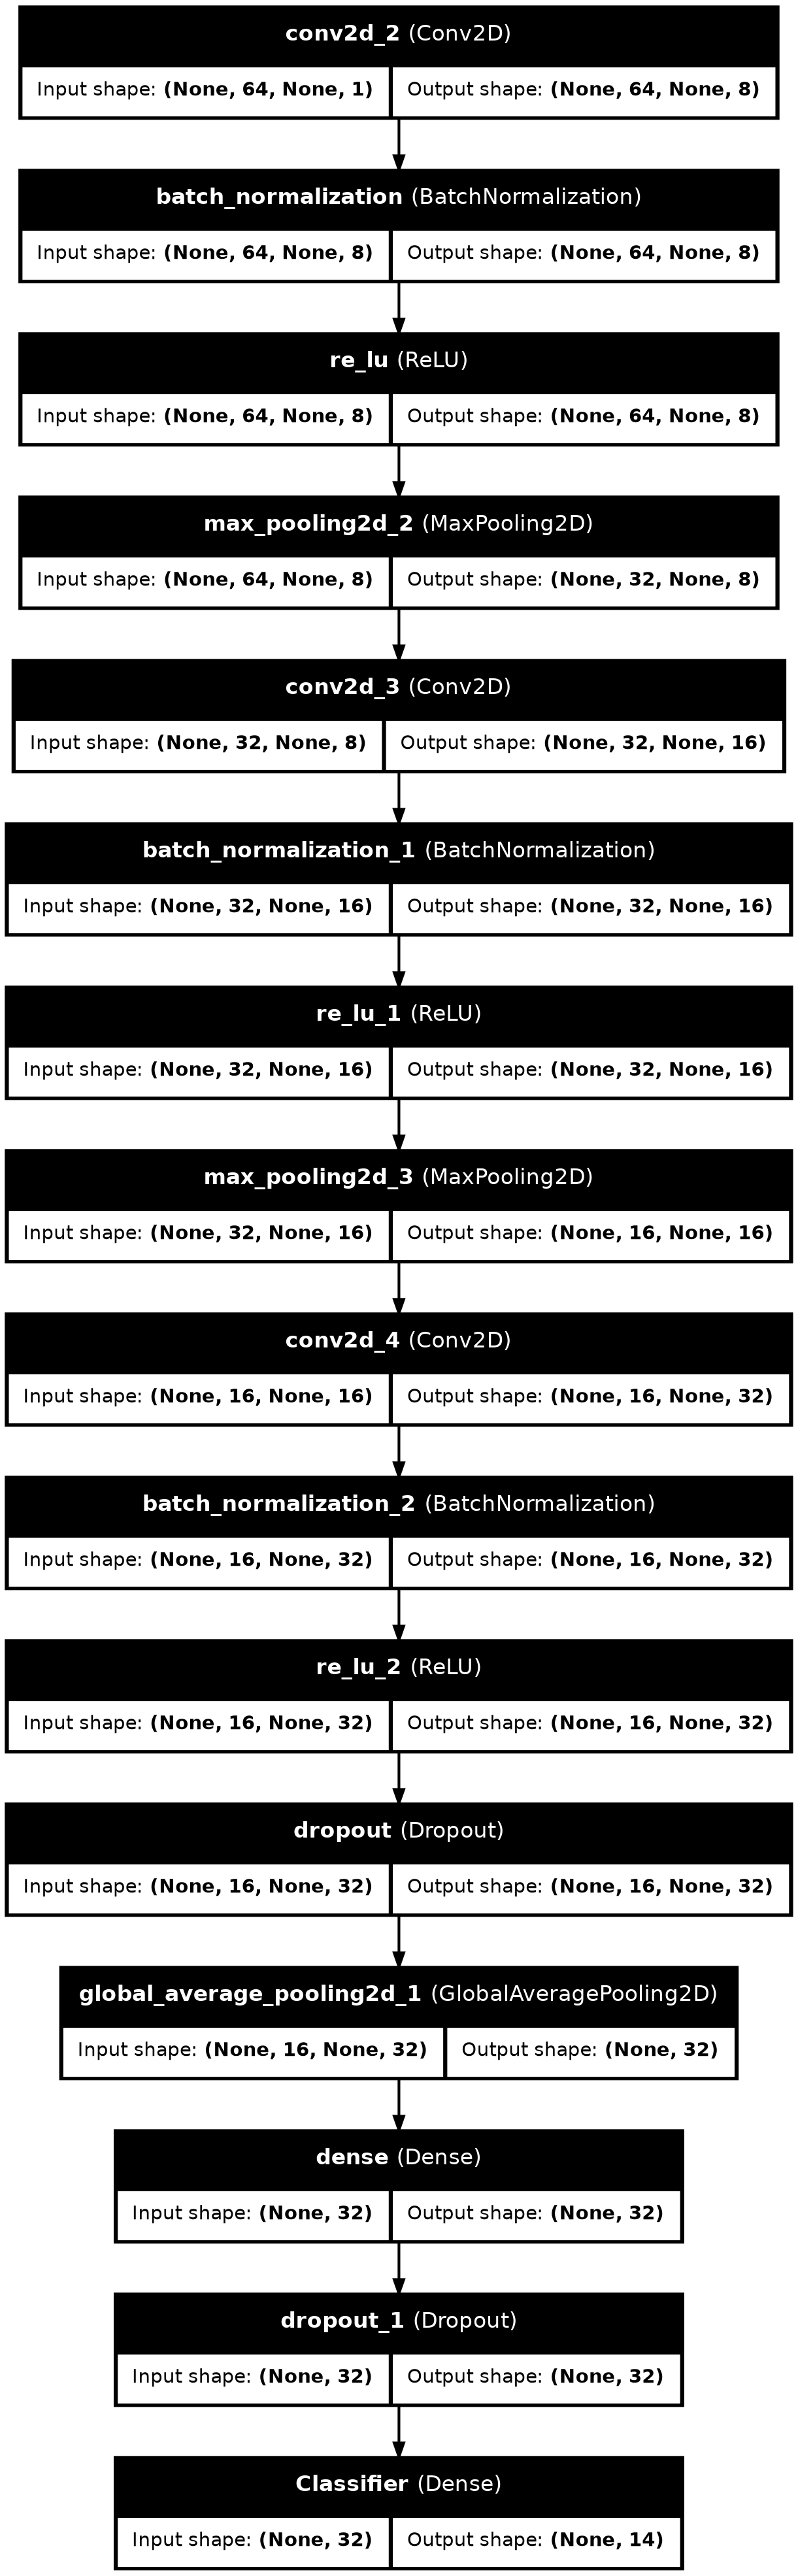

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(enhanced_model_cnn, to_file="../output/model_architecture/enhanced_model_cnn.png",
           show_shapes=True, show_layer_names=True,
           expand_nested=True, dpi=150)
display(Image(filename="../output/model_architecture/enhanced_model_cnn.png", width=300))

**Train the enhanced CNN with callbacks**

stop when validation stops improving, adapt LR when plateauing, and keep clean logs

In [ ]:
from tensorflow.keras import callbacks

# Stop when val accuracy stops improving; restore the best weights
es = callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# Reduce LR on validation loss plateau to fine-tune later epochs
rlr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

# Log epoch metrics to CSV for later plotting
log = callbacks.CSVLogger("../output/training_log/enhanced_model_cnn.csv", append=False)

# Train the enhanced CNN
history = enhanced_model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[es, rlr, log],
    verbose=1
)

Epoch 1/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.4884 - loss: 1.6944 - val_accuracy: 0.7080 - val_loss: 1.1071 - learning_rate: 3.0000e-04
Epoch 2/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6722 - loss: 1.0420 - val_accuracy: 0.7953 - val_loss: 0.7135 - learning_rate: 3.0000e-04
Epoch 3/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7409 - loss: 0.7994 - val_accuracy: 0.8639 - val_loss: 0.5441 - learning_rate: 3.0000e-04
Epoch 4/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7947 - loss: 0.6605 - val_accuracy: 0.8613 - val_loss: 0.4563 - learning_rate: 3.0000e-04
Epoch 5/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8222 - loss: 0.5633 - val_accuracy: 0.9167 - val_loss: 0.3415 - learning_rate: 3.0000e-04
Epoch 6/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8477 - loss: 0.4866 - val_accuracy: 0.8873 - val_loss: 0.3815 - learning_rate: 3.0000e-04
Epoch 7/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step -

Evaluate Enhanced CNN Model

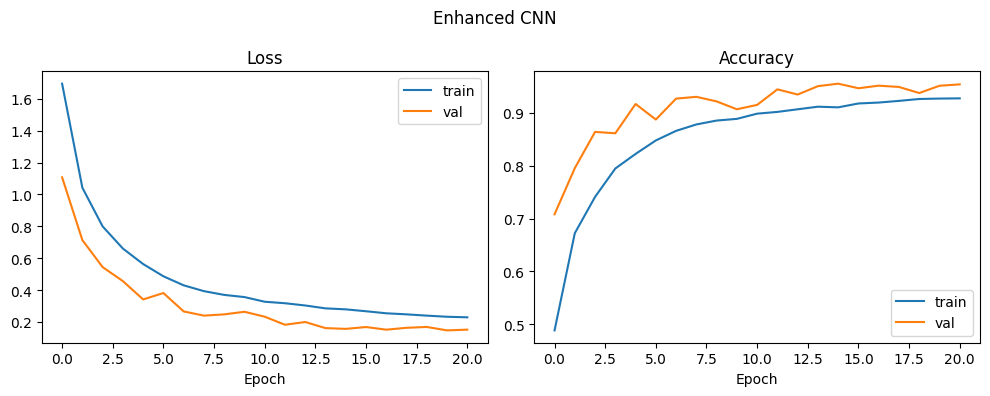

In [41]:
# Plot training curves
plot_training_curves(history, metrics=("loss", "accuracy"), suptitle="Enhanced CNN")

2025-09-25 14:27:52.717288: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Enhanced CNN Test accuracy: 0.9517


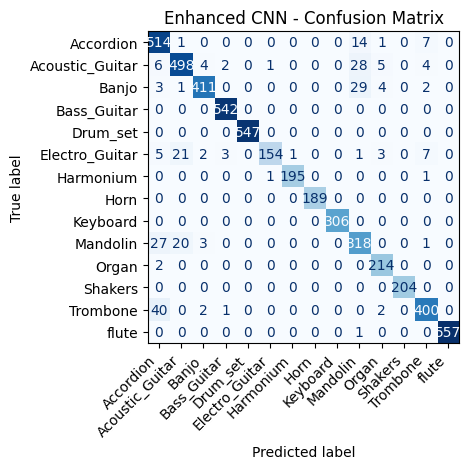


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.861     0.957     0.907       537
Acoustic_Guitar      0.921     0.909     0.915       548
          Banjo      0.974     0.913     0.943       450
    Bass_Guitar      0.989     1.000     0.994       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.987     0.782     0.873       197
      Harmonium      0.995     0.990     0.992       197
           Horn      1.000     1.000     1.000       189
       Keyboard      1.000     1.000     1.000       306
       Mandolin      0.813     0.862     0.837       369
          Organ      0.934     0.991     0.962       216
        Shakers      1.000     1.000     1.000       204
       Trombone      0.948     0.899     0.923       445
          flute      1.000     0.998     0.999       558

       accuracy                          0.952      5305
      macro avg      0.959     0.950     0.953      5305
   w

In [42]:
# Evaluate model
results = evaluate_model(
    model=enhanced_model_cnn,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Enhanced CNN",
    normalize_cm=False
)

In [ ]:
# Save model
enhanced_model_cnn.save("../output/model/enhanced_model_cnn.keras")

---

Hyperparameter Tuning CNN

In [ ]:
import os, json, itertools, gc, hashlib, time, numpy as np, tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, regularizers, callbacks, backend as K
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility by fix seeds for TF and NumPy
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seed(42)

# Directory to save all trial logs and checkpoints
RUNS_DIR = "../output/model/cnn_grid_runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# Reduce TensorFlow verbosity in console
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

Model factory for tuning

In [ ]:
def build_model(input_shape, num_classes, p):
    # Optional L2 regularization
    l2 = regularizers.l2(p["l2_strength"]) if p["l2_strength"] > 0 else None
    ks = p["kernel_size"]   # kernel size tuple
    ps = p["pool_size"]     # pooling size tuple

    model = Sequential(name="enhanced_model_cnn")
    model.add(layers.Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(p["conv_filters"][0], ks, padding="same", kernel_regularizer=l2))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=ps))

    # Block 2
    model.add(layers.Conv2D(p["conv_filters"][1], ks, padding="same", kernel_regularizer=l2))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=ps))

    # Block 3
    model.add(layers.Conv2D(p["conv_filters"][2], ks, padding="same", kernel_regularizer=l2))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(p["dropout_block3"]))

    # Head
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(p["dense_units"], activation="relu", kernel_regularizer=l2))
    model.add(layers.Dropout(p["dropout_head"]))
    model.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

    # Optimizer configured per trial
    opt = optimizers.Adam(learning_rate=p["learning_rate"])
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

CNN hyperparameter grid

In [ ]:
# 3 x 2 x 2 x 2 x 2 x 2 = 96 trials
param_grid = {
    "conv_filters": [(8,16,32), (16,32,64), (24,48,96)],  # depth per block
    "kernel_size": [(3,3)],                               # 3x3 convs (standard choice)
    "pool_size": [(2,2)],                                 # downsample after blocks
    "dropout_block3": [0.30, 0.40],                       # regularize last conv block
    "dense_units": [64, 128],                             # head width
    "dropout_head": [0.30, 0.50],                         # regularize dense head
    "learning_rate": [3e-4, 1e-4],                        # Adam LR candidates
    "l2_strength": [0.0, 1e-4],                           # weight decay (0 = off)
    "epochs": [30],                                       # fixed training budget per trial
    "batch_size": [32],                                   # keep memory use stable
}

**Trial runner** to generate IDs, train one CNN trial, and log results

keep each trial isolated, reproducible, and easy to compare

In [ ]:
def dict_product(d):
    # Cartesian product over parameter lists to dicts
    keys = list(d.keys())
    for values in itertools.product(*[d[k] for k in keys]):
        yield dict(zip(keys, values))

def short_id_from_params(p):
    # Short, readable ID from params (stable across runs)
    key_str = json.dumps(p, sort_keys=True)
    return hashlib.md5(key_str.encode()).hexdigest()[:8]

def train_one_trial(p, input_shape, num_classes, train_ds, val_ds):
    run_id = short_id_from_params(p)
    run_dir = os.path.join(RUNS_DIR, run_id)
    os.makedirs(run_dir, exist_ok=True)

    # Per-trial file paths
    csv_path = os.path.join(run_dir, "history.csv")
    ckpt_path = os.path.join(run_dir, "best.weights.h5")

    # Callbacks: CSV log, best-weight checkpoint (by val_accuracy), early stopping
    cbs = [
        callbacks.CSVLogger(csv_path, append=False),
        callbacks.ModelCheckpoint(
            ckpt_path,
            save_weights_only=True,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            verbose=0
        ),
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=6,
            restore_best_weights=True,
            verbose=0
        ),
    ]

    # Build model for this param set
    model = build_model(input_shape, num_classes, p)

    # Train quietly (verbose=0) to avoid console crash from too many text
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=p["epochs"],
        batch_size=p["batch_size"],
        verbose=0,
        callbacks=cbs
    )

    # Ensure we evaluate the best checkpointed weights
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)

    # Validation metrics used for model selection
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

    # Save a compact JSON summary for later aggregation
    with open(os.path.join(run_dir, "summary.json"), "w") as f:
        json.dump({"params": p, "val_loss": float(val_loss), "val_accuracy": float(val_acc)}, f, indent=2)

    print(f"[{run_id}] val_acc={val_acc:.4f} | params={p}")
    return run_id, val_acc, val_loss, run_dir, model

In [ ]:
def count_trials(pg):
    # Multiply lengths of all value lists to get Cartesian product size
    total = 1
    for k, vals in pg.items():
        total *= len(vals)
    return total

TOTAL_TRIALS = count_trials(param_grid)
print(f"Total Trials: {TOTAL_TRIALS}")

Total Trials: 96


**Prepare live summary CSV for grid runs**

record everything for progress tracking and later aggregation 

In [ ]:
import sys, json, os

# Path to CSV that logs each trial's summary
LIVE_CSV = os.path.join(RUNS_DIR, "grid_summary_live.csv")

# Create the CSV with header
if not os.path.exists(LIVE_CSV):
    with open(LIVE_CSV, "w") as f:
        f.write("idx,run_id,val_accuracy,val_loss,params_json\n")
        f.flush(); os.fsync(f.fileno())

Run the CNN grid search

In [ ]:
# Input shape for log-Mel tensors and containers for results
input_shape = (num_mel_bins, None, 1)
results = []
best = {"val_acc": -1, "run_id": None, "run_dir": None, "params": None}
start_all = time.time()

# Iterate over all parameter combinations
for i, p in enumerate(dict_product(param_grid), start=1):
    K.clear_session(); gc.collect(); set_seed(42)
    t0 = time.time()
    model = None
    try:
        # Train one trial and collect metrics
        run_id, val_acc, val_loss, run_dir, model = train_one_trial(
            p, input_shape, num_classes, train_ds, val_ds
        )
        results.append({"run_id": run_id, "val_accuracy": float(val_acc), "val_loss": float(val_loss), "params": p})

        # Track best model so far and persist weights immediately
        if val_acc > best["val_acc"]:
            best.update({"val_acc": val_acc, "run_id": run_id, "run_dir": run_dir, "params": p})
            best_weights_path = os.path.join(RUNS_DIR, "best_overall.weights.h5")
            model.save_weights(best_weights_path)

        # single-line progress output
        p_show = {
            "filters": p["conv_filters"], "ks": p["kernel_size"], "ps": p["pool_size"],
            "drop3": p["dropout_block3"], "dense": p["dense_units"], "dropH": p["dropout_head"],
            "lr": p["learning_rate"], "l2": p["l2_strength"], "bs": p["batch_size"], "ep": p["epochs"],
        }
        elapsed = time.time() - t0
        line = f"[{i}/{TOTAL_TRIALS}] {run_id} val_acc={val_acc:.4f} val_loss={val_loss:.4f} | {p_show} | {elapsed:.1f}s"
        print(line); sys.stdout.flush()  # force print in notebook

        # Append to progress.log (text) with fsync
        with open(os.path.join(RUNS_DIR, "progress.log"), "a") as f:
            f.write(line + "\n"); f.flush(); os.fsync(f.fileno())

        # Append to live CSV with fsync
        with open(LIVE_CSV, "a") as f:
            params_json = json.dumps(p, sort_keys=True).replace(",", ";")
            f.write(f"{i},{run_id},{val_acc:.6f},{val_loss:.6f},{params_json}\n")
            f.flush(); os.fsync(f.fileno())

    finally:
        # Clean up model and free graph memory between trials
        if model is not None:
            del model
        K.clear_session(); gc.collect()

# Total wall-clock time for the entire grid
total_time = time.time() - start_all

[350bd261] val_acc=0.9815 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 64, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0, 'epochs': 30, 'batch_size': 32}
[1/96] 350bd261 val_acc=0.9815 val_loss=0.0686 | {'filters': (8, 16, 32), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 64, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0, 'bs': 32, 'ep': 30} | 407.0s
[791ee877] val_acc=0.9787 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 64, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0001, 'epochs': 30, 'batch_size': 32}
[2/96] 791ee877 val_acc=0.9787 val_loss=0.0922 | {'filters': (8, 16, 32), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 64, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0001, 'bs': 32, 'ep': 30} | 404.9s
[4b38f5ee] val_acc=0.9627 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_size': (

2025-09-25 15:58:26.972874: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_143', 20 bytes spill stores, 20 bytes spill loads



[b51b1750] val_acc=0.9823 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0, 'epochs': 30, 'batch_size': 32}
[9/96] b51b1750 val_acc=0.9823 val_loss=0.0645 | {'filters': (8, 16, 32), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0, 'bs': 32, 'ep': 30} | 408.4s
[4990b790] val_acc=0.9817 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0001, 'epochs': 30, 'batch_size': 32}
[10/96] 4990b790 val_acc=0.9817 val_loss=0.0863 | {'filters': (8, 16, 32), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0001, 'bs': 32, 'ep': 30} | 435.7s
[b32a6362] val_acc=0.9697 | params={'conv_filters': (8, 16, 32), 'kernel_size': (3, 3), 'pool_siz

2025-09-25 19:50:34.829670: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 19:50:52.927045: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


[ec01b23c] val_acc=0.9921 | params={'conv_filters': (16, 32, 64), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0, 'epochs': 30, 'batch_size': 32}
[41/96] ec01b23c val_acc=0.9921 val_loss=0.0300 | {'filters': (16, 32, 64), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0, 'bs': 32, 'ep': 30} | 518.7s
[3913353e] val_acc=0.9887 | params={'conv_filters': (16, 32, 64), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0001, 'epochs': 30, 'batch_size': 32}
[42/96] 3913353e val_acc=0.9887 val_loss=0.0656 | {'filters': (16, 32, 64), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0001, 'bs': 32, 'ep': 30} | 533.9s
[144620be] val_acc=0.9836 | params={'conv_filters': (16, 32, 64), 'kernel_size': (3, 3), 'po

2025-09-25 23:17:45.957645: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 23:17:45.957761: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-25 23:17:47.745641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1893', 240 bytes spill stores, 240 bytes spill loads

2025-09-25 23:18:09.507018: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were 

[6415b554] val_acc=0.9857 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 64, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0, 'epochs': 30, 'batch_size': 32}
[65/96] 6415b554 val_acc=0.9857 val_loss=0.0654 | {'filters': (24, 48, 96), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 64, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0, 'bs': 32, 'ep': 30} | 394.7s
[c5255be5] val_acc=0.9853 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 64, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0001, 'epochs': 30, 'batch_size': 32}
[66/96] c5255be5 val_acc=0.9853 val_loss=0.0750 | {'filters': (24, 48, 96), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 64, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0001, 'bs': 32, 'ep': 30} | 373.0s
[2416164b] val_acc=0.9844 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'pool_s

2025-09-26 00:22:20.331006: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-26 00:22:20.331052: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-26 00:22:20.331063: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-26 00:22:22.464664: I external/l

[8729b734] val_acc=0.9857 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0, 'epochs': 30, 'batch_size': 32}
[73/96] 8729b734 val_acc=0.9857 val_loss=0.0474 | {'filters': (24, 48, 96), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0, 'bs': 32, 'ep': 30} | 360.5s
[0d51fe50] val_acc=0.9861 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'pool_size': (2, 2), 'dropout_block3': 0.3, 'dense_units': 128, 'dropout_head': 0.3, 'learning_rate': 0.0003, 'l2_strength': 0.0001, 'epochs': 30, 'batch_size': 32}
[74/96] 0d51fe50 val_acc=0.9861 val_loss=0.0822 | {'filters': (24, 48, 96), 'ks': (3, 3), 'ps': (2, 2), 'drop3': 0.3, 'dense': 128, 'dropH': 0.3, 'lr': 0.0003, 'l2': 0.0001, 'bs': 32, 'ep': 30} | 300.2s
[3f34e1af] val_acc=0.9857 | params={'conv_filters': (24, 48, 96), 'kernel_size': (3, 3), 'po

Summarize grid results

In [ ]:
import pandas as pd

# Read live results, sort by validation accuracy (desc), and show top-10
df_results = pd.read_csv(LIVE_CSV)
df_results = df_results.sort_values("val_accuracy", ascending=False)
pd.set_option("display.max_rows", 12)
pd.set_option("display.max_colwidth", 60)

print("Top 10 Trials by Val Accuracy:")
display(df_results.head(10)[["idx","run_id","val_accuracy","val_loss"]].round(4))

print(f"Trials: {len(df_results)} | Elapsed: {total_time/60:.1f} min")

Top 10 Trials by Val Accuracy:


idx    run_id  val_accuracy  val_loss
76   77  acb30593        0.9945    0.0221
40   41  ec01b23c        0.9921    0.0300
32   33  ab39039c        0.9913    0.0360
61   62  78040c1a        0.9913    0.0571
89   90  458afd3e        0.9913    0.0622
77   78  9f1a3709        0.9913    0.0658
82   83  de0762cd        0.9910    0.0382
68   69  029f04f9        0.9910    0.0365
75   76  5a79e648        0.9910    0.0656
60   61  49fad348        0.9908    0.0316

Trials: 96 | Elapsed: 742.0 min


In [5]:
best = df_results.iloc[0]
params_str = str(best["params_json"]).replace(";", ",")
best_params = json.loads(params_str)

print("\nBest hyperparameters:")
print(json.dumps(best_params, indent=2, sort_keys=True))


Best hyperparameters:
{
  "batch_size": 32,
  "conv_filters": [
    24,
    48,
    96
  ],
  "dense_units": 128,
  "dropout_block3": 0.3,
  "dropout_head": 0.5,
  "epochs": 30,
  "kernel_size": [
    3,
    3
  ],
  "l2_strength": 0.0,
  "learning_rate": 0.0003,
  "pool_size": [
    2,
    2
  ]
}


Reload best model from the grid and restore weights

In [ ]:
# Reload best model to plot curves and evaluate
import os, json, pandas as pd, numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Recover best params/run_id even if the session restarted
def _recover_best(RUNS_DIR, best_dict=None):
    # If current session tracked a best dict, use it
    if best_dict and best_dict.get("run_id"):
        return best_dict["run_id"], best_dict["params"]
    
    # Otherwise, read the leaderboard CSV (prefer final, fallback to live)
    grid_csv = os.path.join(RUNS_DIR, "grid_summary.csv")
    if not os.path.exists(grid_csv):
        grid_csv = os.path.join(RUNS_DIR, "grid_summary_live.csv")

    df = pd.read_csv(grid_csv)
    top = df.sort_values("val_accuracy", ascending=False).iloc[0]
    run_id = top["run_id"]
    
    # Params may be embedded as JSON or stored in the trial's summary.json
    if "params_json" in df.columns:
        params = json.loads(top["params_json"])
    else:
        with open(os.path.join(RUNS_DIR, run_id, "summary.json"), "r") as f:
            params = json.load(f)["params"]
    return run_id, params

best_run_id, best_params = _recover_best(RUNS_DIR, best)

# Build and load weights for the best model
best_model = build_model(input_shape, num_classes, best_params)
best_weights = os.path.join(RUNS_DIR, "best_overall.weights.h5")
best_model.load_weights(best_weights)

In [86]:
best_model.summary()

Model: "enhanced_model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, None, 24)   │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, None, 24)   │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 64, None, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, None, 24)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, None, 48)   │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, None, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 32, None, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, None, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, None, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, None, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 16, None, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, None, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,118 (262.18 KB)

 Trainable params: 66,782 (260.87 KB)

 Non-trainable params: 336 (1.31 KB)

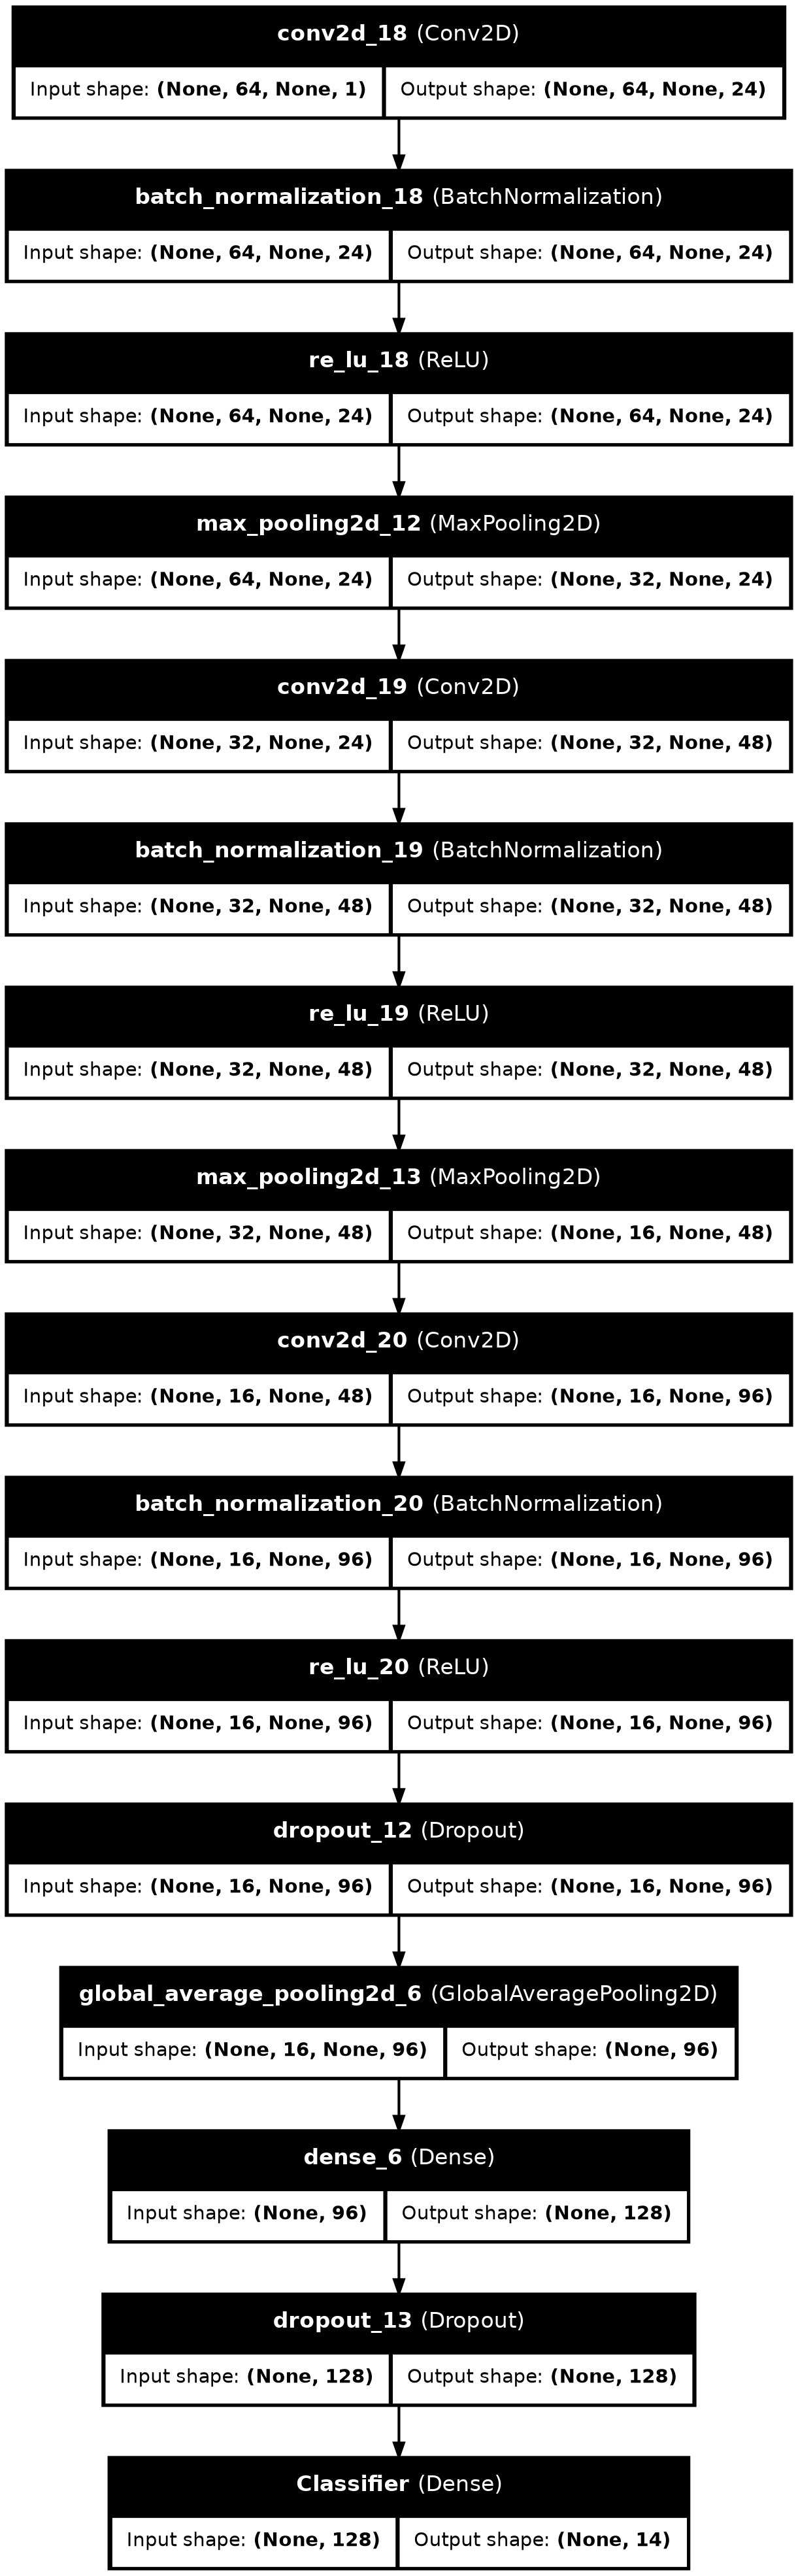

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(
    best_model,
    to_file="../output/model_architecture/best_tuned_cnn.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=150
)
display(Image(filename="../output/model_architecture/best_tuned_cnn.png", width=300))

Evaluate the best tuned CNN model

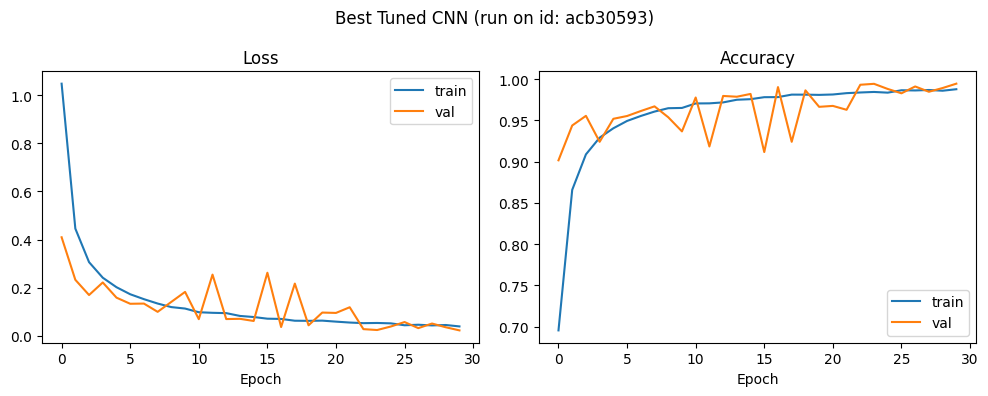

In [ ]:
# Recreate a History-like object from the best trial's history.csv for plotting
hist_path = os.path.join(RUNS_DIR, best_run_id, "history.csv")
if os.path.exists(hist_path):
    hist_df = pd.read_csv(hist_path)

    # Minimal shim that mimics Keras History structure
    class _SimpleHistory:
        pass
    history_for_plot = _SimpleHistory()

    # Convert CSV columns to lists; ignore 'epoch' if present
    hist_cols = [c for c in hist_df.columns if c != "epoch"]
    history_for_plot.history = {c: hist_df[c].tolist() for c in hist_cols}

# Plot training curves for the best tuned CNN
plot_training_curves(
    history_for_plot,
    metrics=("loss", "accuracy"),
    suptitle=f"Best Tuned CNN (run on id: {best_run_id})"
)

2025-09-26 03:54:35.428075: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Best Tuned CNN Test accuracy: 0.9962


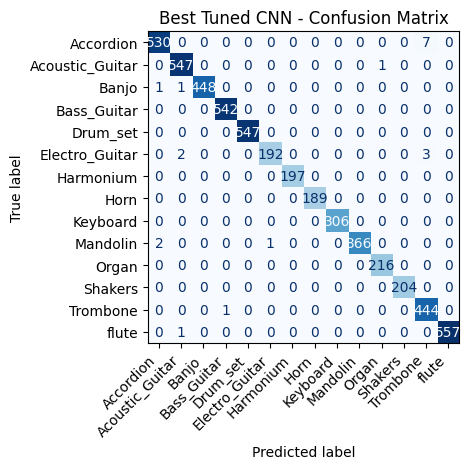


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.994     0.987     0.991       537
Acoustic_Guitar      0.993     0.998     0.995       548
          Banjo      1.000     0.996     0.998       450
    Bass_Guitar      0.998     1.000     0.999       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.995     0.975     0.985       197
      Harmonium      1.000     1.000     1.000       197
           Horn      1.000     1.000     1.000       189
       Keyboard      1.000     1.000     1.000       306
       Mandolin      1.000     0.992     0.996       369
          Organ      0.995     1.000     0.998       216
        Shakers      1.000     1.000     1.000       204
       Trombone      0.978     0.998     0.988       445
          flute      1.000     0.998     0.999       558

       accuracy                          0.996      5305
      macro avg      0.997     0.996     0.996      5305
   w

In [ ]:
# Confusion matrix and Classification report
results = evaluate_model(
    model=best_model,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Best Tuned CNN",
    normalize_cm=False
)

In [ ]:
# Save model
best_model.save(os.path.join(RUNS_DIR, "best_overall.keras"))
best_model.save(os.path.join("../output/model/best_tuned_cnn.keras"))

------

**Build Baseline RNN Model**

simple two-layer Bidirectional GRU on log-Mel sequences

In [ ]:
from tensorflow.keras import Sequential, layers, optimizers

# Input: mel spectrograms shaped (num_mel_bins, time, 1)
input_shape = (num_mel_bins, None, 1)

base_model_rnn = Sequential(name="base_model_rnn")
base_model_rnn.add(layers.Input(shape=input_shape))

# Flatten frequency/channel so RNN sees sequences of mel bins
# From (batch, mel_bins, time, 1) -> (batch, time, mel_bins)
base_model_rnn.add(layers.Permute((2, 1, 3)))
base_model_rnn.add(layers.Lambda(lambda x: tf.squeeze(x, axis=-1), name="squeeze_chan"))

# Block 1: BiGRU
base_model_rnn.add(layers.Bidirectional(layers.GRU(8, return_sequences=True), name="bigru_8"))

# Block 2: BiGRU
base_model_rnn.add(layers.Bidirectional(layers.GRU(8), name="bigru2_8"))

# Head
base_model_rnn.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

# Use same optimizer/loss as CNN baseline
base_model_rnn.compile(
    optimizer=optimizers.SGD(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

base_model_rnn.summary()

Model: "base_model_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, None, 64, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squeeze_chan (Lambda)           │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_8 (Bidirectional)         │ (None, None, 16)       │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru2_8 (Bidirectional)        │ (None, 16)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │           238 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,038 (19.68 KB)

 Trainable params: 5,038 (19.68 KB)

 Non-trainable params: 0 (0.00 B)

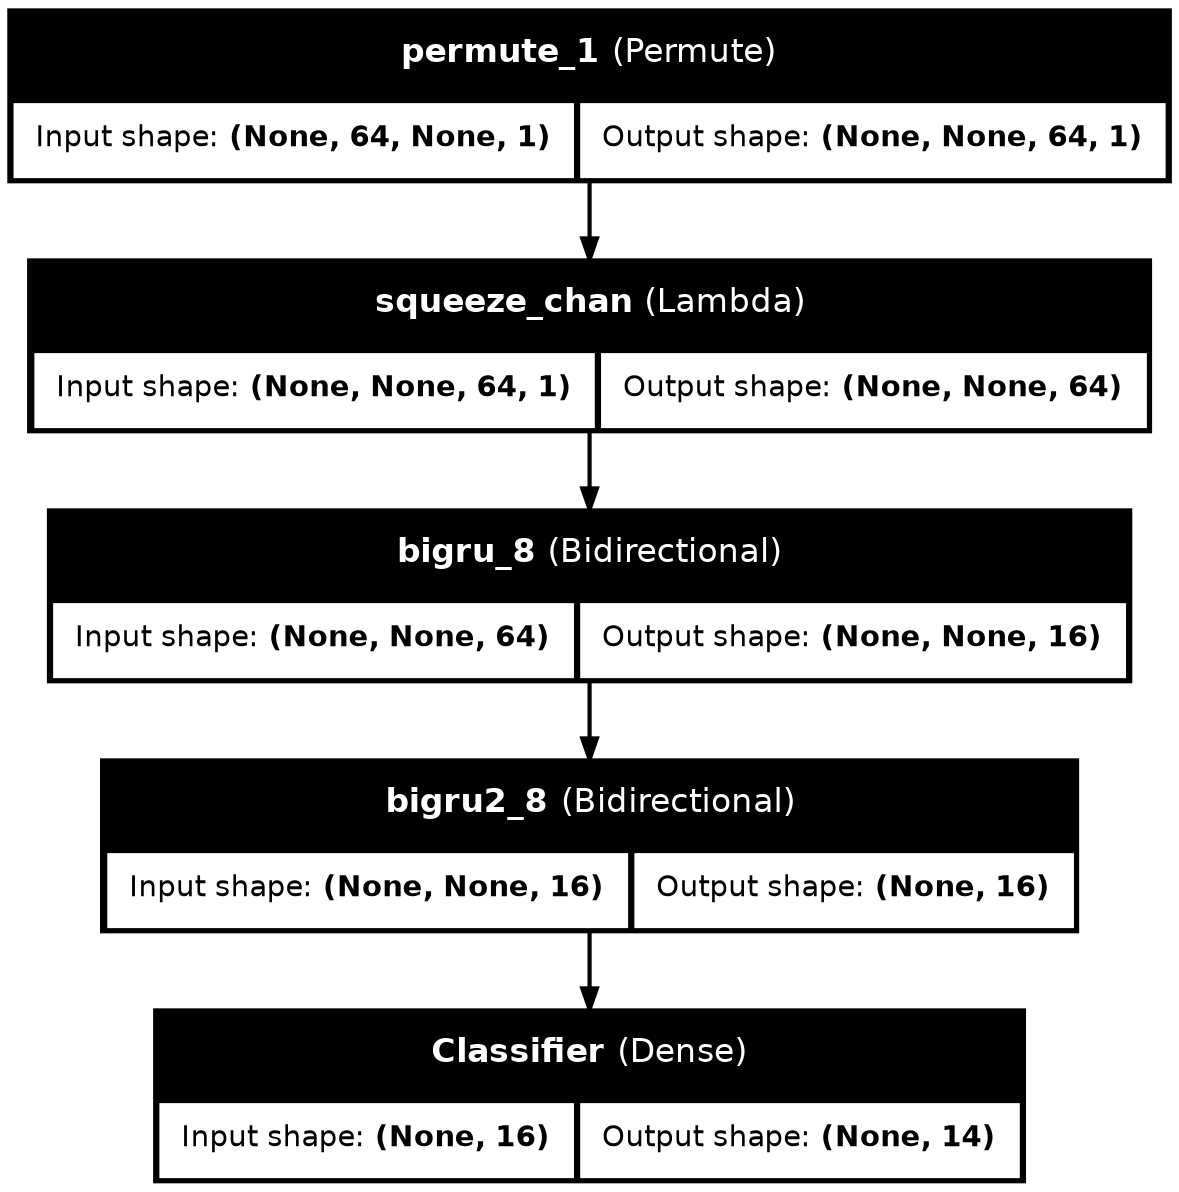

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(base_model_rnn, to_file="../output/model_architecture/base_model_rnn.png",
           show_shapes=True, show_layer_names=True,
           expand_nested=True, dpi=150)

display(Image(filename="../output/model_architecture/base_model_rnn.png", width=450))

Train the Baseline RNN

In [ ]:
from tensorflow.keras import callbacks

# Log epoch-by-epoch metrics to a CSV
log = callbacks.CSVLogger("../output/training_log/base_model_rnn.csv", append=False)

# Train baseline RNN on log-Mel inputs
history = base_model_rnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=log,
    verbose=1
)

Epoch 1/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 55s 69ms/step - accuracy: 0.4838 - loss: 1.7648 - val_accuracy: 0.6017 - val_loss: 1.3750
Epoch 2/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.6744 - loss: 1.1722 - val_accuracy: 0.7374 - val_loss: 1.0142
Epoch 3/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.7649 - loss: 0.8918 - val_accuracy: 0.7908 - val_loss: 0.7953
Epoch 4/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.8079 - loss: 0.7213 - val_accuracy: 0.8215 - val_loss: 0.6613
Epoch 5/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - accuracy: 0.8300 - loss: 0.6143 - val_accuracy: 0.8320 - val_loss: 0.5940
Epoch 6/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.8486 - loss: 0.5422 - val_accuracy: 0.8513 - val_loss: 0.5244
Epoch 7/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.8592 - loss: 0.4914 - val_accuracy: 0.8556 - val_loss: 0.4930
Epoch 8/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.8685 - loss: 0.4487 - 

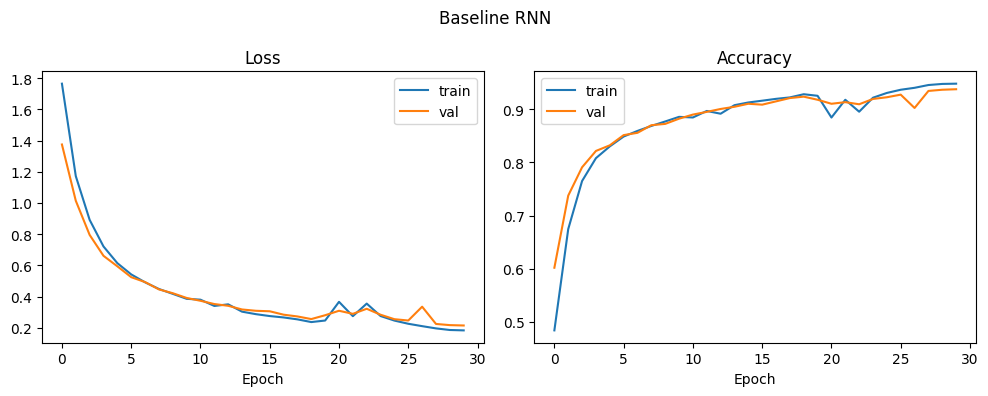

In [44]:
# Plot training curves
plot_training_curves(history, metrics=("loss", "accuracy"), suptitle="Baseline RNN")

Baseline RNN Test accuracy: 0.9402


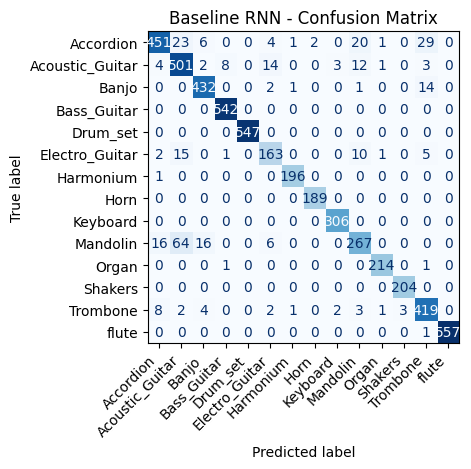


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.936     0.840     0.885       537
Acoustic_Guitar      0.828     0.914     0.869       548
          Banjo      0.939     0.960     0.949       450
    Bass_Guitar      0.982     1.000     0.991       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.853     0.827     0.840       197
      Harmonium      0.985     0.995     0.990       197
           Horn      0.990     1.000     0.995       189
       Keyboard      0.984     1.000     0.992       306
       Mandolin      0.853     0.724     0.783       369
          Organ      0.982     0.991     0.986       216
        Shakers      0.986     1.000     0.993       204
       Trombone      0.888     0.942     0.914       445
          flute      1.000     0.998     0.999       558

       accuracy                          0.940      5305
      macro avg      0.943     0.942     0.942      5305
   w

In [45]:
# Evaluate model
results = evaluate_model(
    model=base_model_rnn,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Baseline RNN",
    normalize_cm=False
)

In [ ]:
# Save model
base_model_rnn.save("../output/model/base_model_rnn.keras")

---

**Enhanced RNN**

with masking and dropout to handle variable-length time axes and improve sequence modeling

In [31]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers

input_shape = (num_mel_bins, None, 1)

enhanced_model_rnn = Sequential(name="enhanced_model_rnn")
enhanced_model_rnn.add(layers.Input(shape=input_shape))

# Adapt CNN-style tensors to RNN sequence format
enhanced_model_rnn.add(layers.Permute((2, 1, 3), name="permute_time_first"))     # (time, mel, 1)
enhanced_model_rnn.add(layers.Lambda(lambda x: tf.squeeze(x, axis=-1), name="squeeze_chan"))  # (time, mel)

# Block 1: BiGRU with dropout, return full sequence
enhanced_model_rnn.add(layers.Bidirectional(
    layers.GRU(16, dropout=0.3, return_sequences=True),
    name=f"bigru_16"
))

# Block 2: BiGRU with dropout, last output only
enhanced_model_rnn.add(layers.Bidirectional(
    layers.GRU(16, dropout=0.3, return_sequences=False),
    name=f"bigru2_16"
))

# Small dense head
enhanced_model_rnn.add(layers.Dense(32, activation="relu", name="head_dense_32"))
enhanced_model_rnn.add(layers.Dropout(0.3, name="head_dropout"))

# Classifier
enhanced_model_rnn.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

# Optimizer
enhanced_model_rnn.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

enhanced_model_rnn.summary()

Model: "enhanced_model_rnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_time_first (Permute)    │ (None, None, 64, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squeeze_chan (Lambda)           │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_16 (Bidirectional)        │ (None, None, 32)       │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru2_16 (Bidirectional)       │ (None, 32)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense_32 (Dense)           │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,190 (55.43 KB)

 Trainable params: 14,190 (55.43 KB)

 Non-trainable params: 0 (0.00 B)

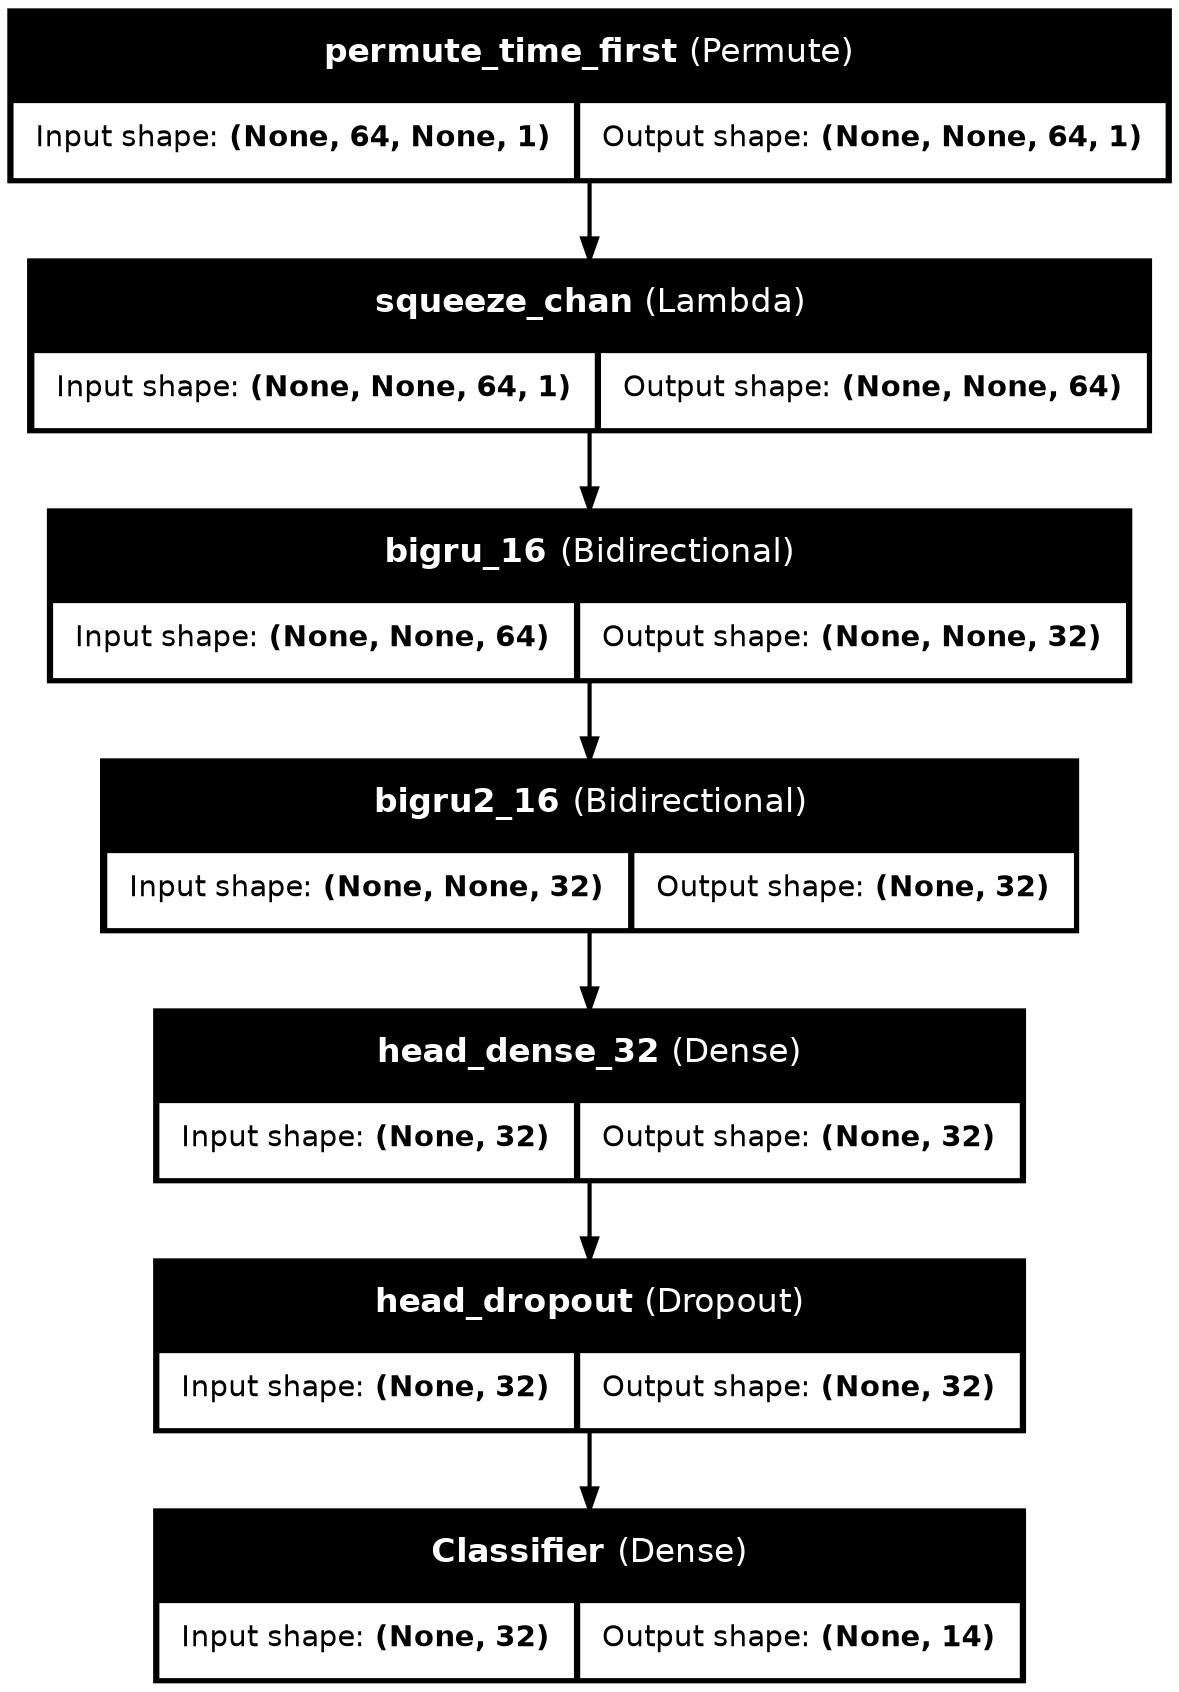

In [33]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(enhanced_model_rnn, to_file="../output/model_architecture/enhanced_model_rnn.png",
           show_shapes=True, show_layer_names=True,
           expand_nested=True, dpi=150)
display(Image(filename="../output/model_architecture/enhanced_model_rnn.png", width=450))

Train the enhanced RNN

In [35]:
from tensorflow.keras import callbacks

# Stop when validation accuracy stops improving
es = callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# Halve the learning rate if validation loss plateaus
rlr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

# Log epoch metrics to CSV
log = callbacks.CSVLogger("../output/training_log/enhanced_model_rnn.csv", append=False)

# Train the enhanced RNN
history = enhanced_model_rnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[es, rlr, log],
    verbose=1
)

Epoch 1/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.3801 - loss: 1.8858 - val_accuracy: 0.6271 - val_loss: 1.1564 - learning_rate: 3.0000e-04
Epoch 2/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 57s 74ms/step - accuracy: 0.5550 - loss: 1.2851 - val_accuracy: 0.7184 - val_loss: 0.8227 - learning_rate: 3.0000e-04
Epoch 3/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 63s 81ms/step - accuracy: 0.6378 - loss: 1.0379 - val_accuracy: 0.7640 - val_loss: 0.6705 - learning_rate: 3.0000e-04
Epoch 4/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.6937 - loss: 0.8733 - val_accuracy: 0.7868 - val_loss: 0.5765 - learning_rate: 3.0000e-04
Epoch 5/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 69s 90ms/step - accuracy: 0.7270 - loss: 0.7863 - val_accuracy: 0.8196 - val_loss: 0.5035 - learning_rate: 3.0000e-04
Epoch 6/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.7550 - loss: 0.7157 - val_accuracy: 0.8398 - val_loss: 0.4600 - learning_rate: 3.0000e-04
Epoch 7/30
774/774 ━━━━━━━━━━━━━━━━━━━━ 68s 88ms/ste

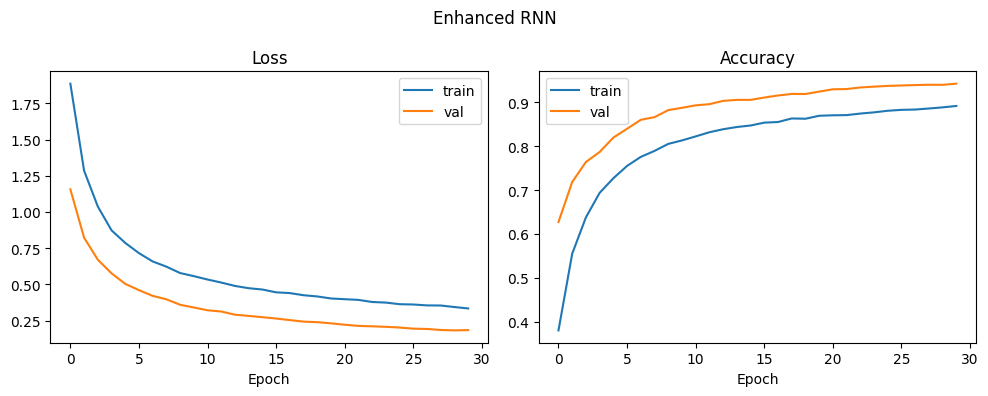

In [36]:
# Plot training curves
plot_training_curves(history, metrics=("loss", "accuracy"), suptitle="Enhanced RNN")

2025-10-04 23:01:28.954634: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Enhanced RNN Test accuracy: 0.9399


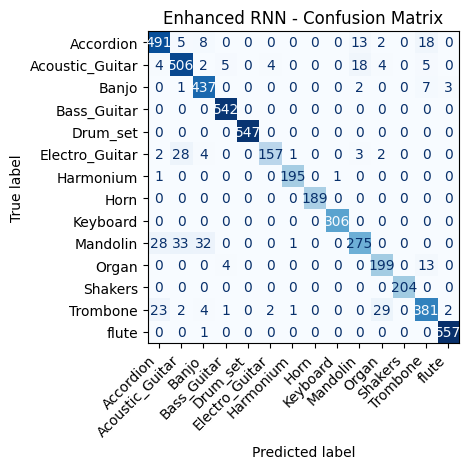


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.894     0.914     0.904       537
Acoustic_Guitar      0.880     0.923     0.901       548
          Banjo      0.895     0.971     0.932       450
    Bass_Guitar      0.982     1.000     0.991       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.963     0.797     0.872       197
      Harmonium      0.985     0.990     0.987       197
           Horn      1.000     1.000     1.000       189
       Keyboard      0.997     1.000     0.998       306
       Mandolin      0.884     0.745     0.809       369
          Organ      0.843     0.921     0.881       216
        Shakers      1.000     1.000     1.000       204
       Trombone      0.899     0.856     0.877       445
          flute      0.991     0.998     0.995       558

       accuracy                          0.940      5305
      macro avg      0.944     0.937     0.939      5305
   w

In [37]:
# Evaluate model
results = evaluate_model(
    model=enhanced_model_rnn,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Enhanced RNN",
    normalize_cm=False
)

In [38]:
# Save model
enhanced_model_rnn.save("../output/model/enhanced_model_rnn.keras")

---

Hyperparameter Tuning RNN

In [39]:
import os, json, itertools, gc, hashlib, time, numpy as np, tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, regularizers, callbacks, backend as K
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility for fix seeds for TF and NumPy
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seed(42)

# Directory for all RNN grid runs, logs and checkpoints
RUNS_DIR = "../output/model/rnn_grid_runs"
os.makedirs(RUNS_DIR, exist_ok=True)

# Reduce TensorFlow console verbosity
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

Model factory for RNN tuning

In [40]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers

def build_model(input_shape, num_classes, p):
    u1, u2 = p["gru_units"]
    dp = float(p["dropout"])

    model = Sequential(name="base_model_rnn_tuned")
    model.add(layers.Input(shape=input_shape))                 # (mel, time, 1)
    
    model.add(layers.Permute((2, 1, 3), name="permute"))      # -> (time, mel, 1)
    model.add(layers.Lambda(lambda x: tf.squeeze(x, axis=-1), name="squeeze"))  # -> (time, mel)

    # Block 1: BiGRU with dropout, return full sequence for stacking
    model.add(layers.Bidirectional(
        layers.GRU(u1, dropout=dp, return_sequences=True),
        name=f"bigru_{u1}"
    ))

    # Block 2: BiGRU with dropout, last output only for classification head
    model.add(layers.Bidirectional(
        layers.GRU(u2, dropout=dp, return_sequences=False),
        name=f"bigru2_{u2}"
    ))

    # Optional small dense head to increase capacity
    if p["use_dense_head"]:
        model.add(layers.Dense(32, activation="relu", name="head_dense_32"))

    # Classifier
    model.add(layers.Dense(num_classes, activation="softmax", name="Classifier"))

    # Optimizer configured per trial
    opt = optimizers.Adam(learning_rate=p["learning_rate"])
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

RNN hyperparameter grid

In [41]:
# 3 * 2 * 1 * 2 * 2 = 24 trials
param_grid = {
    "gru_units": [(32, 16), (32, 32), (64, 32)],  # units for (GRU1, GRU2)
    "dropout": [0.0, 0.3],                        # per-GRU dropout
    "use_dense_head": [False, True],              # optional small dense before classifier
    "learning_rate": [3e-4, 1e-3],                # Adam LR options
    "epochs": [30],                               # fixed budget per trial
    "batch_size": [32],                           # stable memory usage
}

**Trial runner** to isolate each run and make comparisons easy

In [42]:
def dict_product(d):
    # Cartesian product over parameter lists to sequence of dicts
    keys = list(d.keys())
    for values in itertools.product(*[d[k] for k in keys]):
        yield dict(zip(keys, values))

def short_id_from_params(p):
    # Short, stable ID from params (good for folder names)
    key_str = json.dumps(p, sort_keys=True)
    return hashlib.md5(key_str.encode()).hexdigest()[:8]

def train_one_trial(p, input_shape, num_classes, train_ds, val_ds):
    run_id = short_id_from_params(p)
    run_dir = os.path.join(RUNS_DIR, run_id)
    os.makedirs(run_dir, exist_ok=True)

    # File paths per trial
    csv_path = os.path.join(run_dir, "history.csv")
    ckpt_path = os.path.join(run_dir, "best.weights.h5")

    # Callbacks: CSV log, best checkpoint (val_accuracy), early stopping
    cbs = [
        callbacks.CSVLogger(csv_path, append=False),
        callbacks.ModelCheckpoint(
            ckpt_path,
            save_weights_only=True,
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            verbose=0
        ),
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=6,
            restore_best_weights=True,
            verbose=0
        ),
    ]

    # Build and train the model for this param set
    model = build_model(input_shape, num_classes, p)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=p["epochs"],
        batch_size=p["batch_size"],
        verbose=0,
        callbacks=cbs
    )

    # Ensure best weights are loaded before evaluation
    if os.path.exists(ckpt_path):
        model.load_weights(ckpt_path)

    # Validation metrics for selection
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)

    # Persist a compact summary for later aggregation
    with open(os.path.join(run_dir, "summary.json"), "w") as f:
        json.dump({"params": p, "val_loss": float(val_loss), "val_accuracy": float(val_acc)}, f, indent=2)

    print(f"[{run_id}] val_acc={val_acc:.4f} | params={p}")
    return run_id, val_acc, val_loss, run_dir, model

In [43]:
def count_trials(pg):
    # Multiply lengths of all value lists to get Cartesian product size
    total = 1
    for k, vals in pg.items():
        total *= len(vals)
    return total

TOTAL_TRIALS = count_trials(param_grid)
print(f"Total Trials: {TOTAL_TRIALS}")

Total Trials: 24


**Prepare live summary CSV for RNN** grid runs to track progress and build a leaderboard

In [44]:
import sys, json, os

# Path to CSV for trial summaries
LIVE_CSV = os.path.join(RUNS_DIR, "grid_summary_live.csv")

# Initialize the CSV with a header
if not os.path.exists(LIVE_CSV):
    with open(LIVE_CSV, "w") as f:
        f.write("idx,run_id,val_accuracy,val_loss,params_json\n")
        f.flush(); os.fsync(f.fileno())

Run the RNN grid search

In [45]:
# Input shape for log-Mel tensors and containers for results
input_shape = (num_mel_bins, None, 1)
results = []
best = {"val_acc": -1, "run_id": None, "run_dir": None, "params": None}
start_all = time.time()

# Iterate over every parameter combination
for i, p in enumerate(dict_product(param_grid), start=1):
    K.clear_session(); gc.collect(); set_seed(42)  # reset graph and seeds for fair trials
    t0 = time.time()
    model = None
    try:
        # Train a single trial and collect metrics
        run_id, val_acc, val_loss, run_dir, model = train_one_trial(
            p, input_shape, num_classes, train_ds, val_ds
        )
        results.append({"run_id": run_id, "val_accuracy": float(val_acc), "val_loss": float(val_loss), "params": p})

        # Track best model so far and persist weights immediately
        if val_acc > best["val_acc"]:
            best.update({"val_acc": val_acc, "run_id": run_id, "run_dir": run_dir, "params": p})
            best_weights_path = os.path.join(RUNS_DIR, "best_overall.weights.h5")
            model.save_weights(best_weights_path)

        # Concise and single-line progress output
        p_show = {
            "gru": p["gru_units"],
            "drop": p["dropout"],
            "dense_head": p["use_dense_head"],
            "lr": p["learning_rate"],
            "bs": p["batch_size"],
            "ep": p["epochs"],
        }
        elapsed = time.time() - t0
        line = f"[{i}/{TOTAL_TRIALS}] {run_id} val_acc={val_acc:.4f} val_loss={val_loss:.4f} | {p_show} | {elapsed:.1f}s"
        print(line); sys.stdout.flush()  # force print in notebook

        # Append to progress.log (text) with fsync
        with open(os.path.join(RUNS_DIR, "progress.log"), "a") as f:
            f.write(line + "\n"); f.flush(); os.fsync(f.fileno())

        # Append to live CSV with fsync (params JSON with commas replaced)
        with open(LIVE_CSV, "a") as f:
            params_json = json.dumps(p, sort_keys=True).replace(",", ";")
            f.write(f"{i},{run_id},{val_acc:.6f},{val_loss:.6f},{params_json}\n")
            f.flush(); os.fsync(f.fileno())

    finally:
        # Clean up model and free graph memory between trials
        if model is not None:
            del model
        K.clear_session(); gc.collect()

# Total wall-clock time for the entire grid
total_time = time.time() - start_all

[73705c0e] val_acc=0.9947 | params={'gru_units': (32, 16), 'dropout': 0.0, 'use_dense_head': False, 'learning_rate': 0.0003, 'epochs': 30, 'batch_size': 32}
[1/24] 73705c0e val_acc=0.9947 val_loss=0.0248 | {'gru': (32, 16), 'drop': 0.0, 'dense_head': False, 'lr': 0.0003, 'bs': 32, 'ep': 30} | 1976.8s
[57e4c8cf] val_acc=0.9925 | params={'gru_units': (32, 16), 'dropout': 0.0, 'use_dense_head': False, 'learning_rate': 0.001, 'epochs': 30, 'batch_size': 32}
[2/24] 57e4c8cf val_acc=0.9925 val_loss=0.0273 | {'gru': (32, 16), 'drop': 0.0, 'dense_head': False, 'lr': 0.001, 'bs': 32, 'ep': 30} | 1175.2s
[1fa5da5b] val_acc=0.9949 | params={'gru_units': (32, 16), 'dropout': 0.0, 'use_dense_head': True, 'learning_rate': 0.0003, 'epochs': 30, 'batch_size': 32}
[3/24] 1fa5da5b val_acc=0.9949 val_loss=0.0206 | {'gru': (32, 16), 'drop': 0.0, 'dense_head': True, 'lr': 0.0003, 'bs': 32, 'ep': 30} | 1657.6s
[c09fb670] val_acc=0.9926 | params={'gru_units': (32, 16), 'dropout': 0.0, 'use_dense_head': True,

Summarize grid results

In [46]:
import pandas as pd

# Read results CSV and sort descending by validation accuracy
df_results = pd.read_csv(LIVE_CSV)
df_results = df_results.sort_values("val_accuracy", ascending=False)

# Display options for a concise leaderboard
pd.set_option("display.max_rows", 12)
pd.set_option("display.max_colwidth", 60)

print("Top 10 Trials by Val Accuracy:")
display(df_results.head(10)[["idx","run_id","val_accuracy","val_loss"]].round(4))

print(f"Trials: {len(df_results)} | Elapsed: {total_time/60:.1f} min")

Top 10 Trials by Val Accuracy:


idx    run_id  val_accuracy  val_loss
16   17  24c344e8        0.9959    0.0185
18   19  5cdb1571        0.9957    0.0154
19   20  fd7f77f6        0.9951    0.0239
2     3  1fa5da5b        0.9949    0.0206
10   11  c055b7cc        0.9949    0.0193
0     1  73705c0e        0.9947    0.0248
17   18  6d0e489d        0.9945    0.0261
8     9  8d4b5437        0.9936    0.0245
9    10  9d2e366f        0.9936    0.0264
11   12  09bc0f7e        0.9928    0.0274

Trials: 24 | Elapsed: 584.2 min


In [47]:
best = df_results.iloc[0]
params_str = str(best["params_json"]).replace(";", ",")
best_params = json.loads(params_str)

print("\nBest hyperparameters:")
print(json.dumps(best_params, indent=2, sort_keys=True))


Best hyperparameters:
{
  "batch_size": 32,
  "dropout": 0.0,
  "epochs": 30,
  "gru_units": [
    64,
    32
  ],
  "learning_rate": 0.0003,
  "use_dense_head": false
}


Reload best RNN trial and restore weights

In [62]:
# Reload best model, plot curves and evaluate
import os, json, pandas as pd, numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Recover best params/run_id even if the session restarted
def _recover_best(RUNS_DIR, best_dict=None):
    # Read leaderboard CSV (prefer final, fallback to live)
    grid_csv = os.path.join(RUNS_DIR, "grid_summary.csv")
    if not os.path.exists(grid_csv):
        grid_csv = os.path.join(RUNS_DIR, "grid_summary_live.csv")

    df = pd.read_csv(grid_csv)
    top = df.sort_values("val_accuracy", ascending=False).iloc[0]
    run_id = top["run_id"]
    
    # Params stored in the trial's summary.json
    with open(os.path.join(RUNS_DIR, run_id, "summary.json"), "r") as f:
        params = json.load(f)["params"]
    return run_id, params

best_run_id, best_params = _recover_best(RUNS_DIR, best)

# Build and load weights for the best model
best_model = build_model(input_shape, num_classes, best_params)
best_weights = os.path.join(RUNS_DIR, "best_overall.weights.h5")
best_model.load_weights(best_weights)

/mnt/c/Windows/system32/ml/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [57]:
best_model.summary()

Model: "base_model_rnn_tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute (Permute)               │ (None, None, 64, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ squeeze (Lambda)                │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_64 (Bidirectional)        │ (None, None, 128)      │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru2_32 (Bidirectional)       │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier (Dense)              │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,934 (320.05 KB)

 Trainable params: 81,934 (320.05 KB)

 Non-trainable params: 0 (0.00 B)

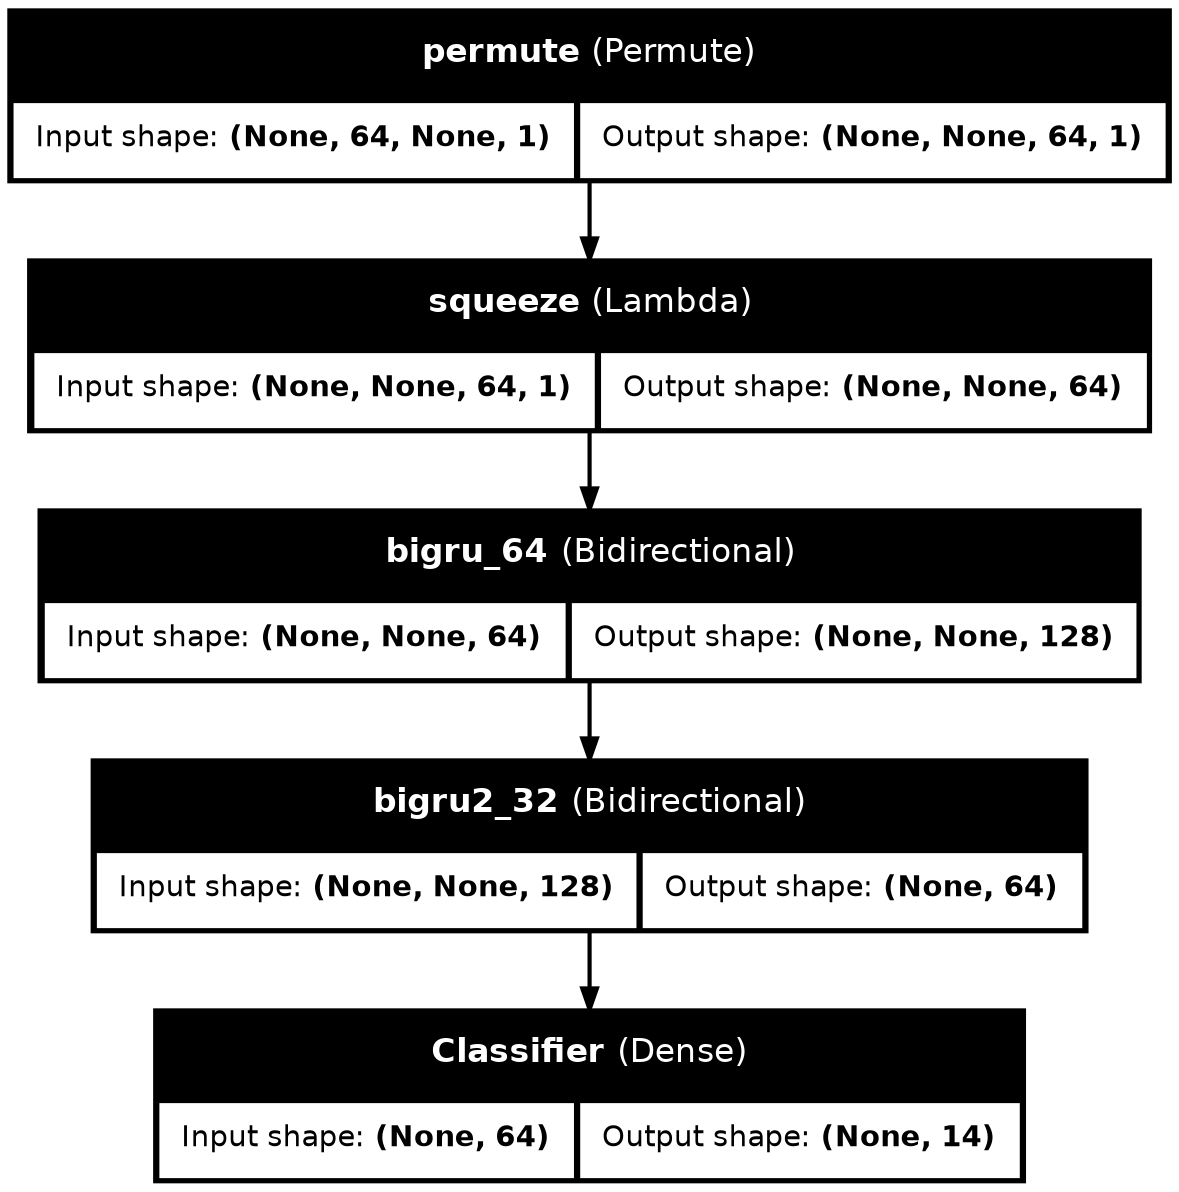

In [58]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Export a PNG of the model graph
plot_model(
    best_model,
    to_file="../output/model_architecture/best_tuned_rnn.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=150
)

display(Image(filename="../output/model_architecture/best_tuned_rnn.png", width=500))

Evaluate the best tuned RNN model

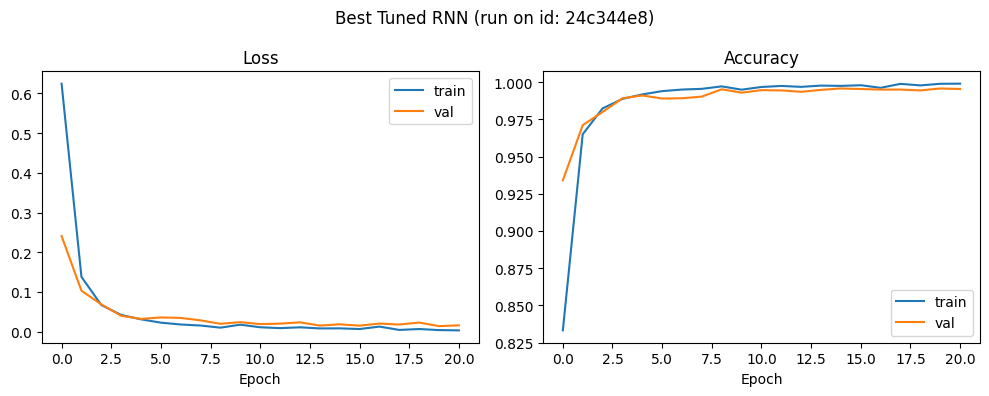

In [59]:
# Recreate a History-like object from the best trial's history.csv for plotting
hist_path = os.path.join(RUNS_DIR, best_run_id, "history.csv")
if os.path.exists(hist_path):
    hist_df = pd.read_csv(hist_path)
    # Keras History-like shim
    class _SimpleHistory:
        pass
    history_for_plot = _SimpleHistory()
    # Ensure lists (drop epoch column if present)
    hist_cols = [c for c in hist_df.columns if c != "epoch"]
    history_for_plot.history = {c: hist_df[c].tolist() for c in hist_cols}

# Plot training curves
plot_training_curves(
    history_for_plot,
    metrics=("loss", "accuracy"),
    suptitle=f"Best Tuned RNN (run on id: {best_run_id})"
)

2025-10-05 10:29:04.536159: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Best Tuned RNN Test accuracy: 0.9943


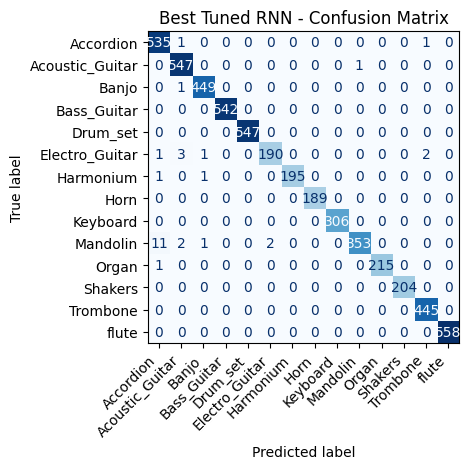


Classification report:

                 precision    recall  f1-score   support

      Accordion      0.974     0.996     0.985       537
Acoustic_Guitar      0.987     0.998     0.993       548
          Banjo      0.993     0.998     0.996       450
    Bass_Guitar      1.000     1.000     1.000       542
       Drum_set      1.000     1.000     1.000       547
 Electro_Guitar      0.990     0.964     0.977       197
      Harmonium      1.000     0.990     0.995       197
           Horn      1.000     1.000     1.000       189
       Keyboard      1.000     1.000     1.000       306
       Mandolin      0.997     0.957     0.976       369
          Organ      1.000     0.995     0.998       216
        Shakers      1.000     1.000     1.000       204
       Trombone      0.993     1.000     0.997       445
          flute      1.000     1.000     1.000       558

       accuracy                          0.994      5305
      macro avg      0.995     0.993     0.994      5305
   w

In [60]:
# Evaluate model
results = evaluate_model(
    model=best_model,
    test_ds=test_ds,
    class_names=class_names,
    model_name="Best Tuned RNN",
    normalize_cm=False
)

In [61]:
# Save model
best_model.save(os.path.join(RUNS_DIR, "best_overall.keras"))
best_model.save(os.path.join("../output/model/best_tuned_rnn.keras"))

---